In [41]:
%load_ext autoreload
%autoreload 2

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns   
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from collections import namedtuple
import os
from utils import Variable


In [4]:
values = read_values()
jan_2023 = values[2023][1]
# # jan_2023['open_date'] = pd.to_datetime(jan_2023['open_time'], unit='ms').dt.strftime('%Y-%m-%d:%H-%M')
# jan_2023['open_date'] = pd.to_datetime(jan_2023['open_time'], unit='ms')
# jan_2023['diff'] =  jan_2023['close'] - jan_2023['open']
# jan_2023['dow'] = jan_2023['open_date'].dt.weekday


Text(0.5, 1.0, 'diff by date')

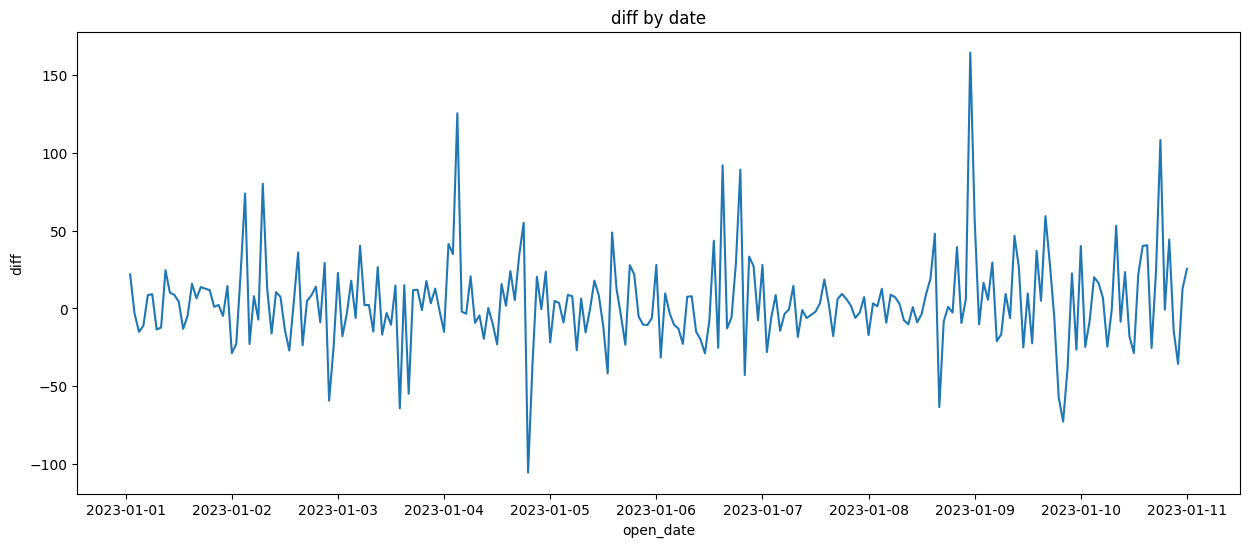

In [6]:
plt.figure(figsize=(15, 6))
sns.lineplot(jan_2023.iloc[:24*10], x = "open_date", y = "diff", )
plt.title('diff by date')

<Figure size 1500x600 with 0 Axes>

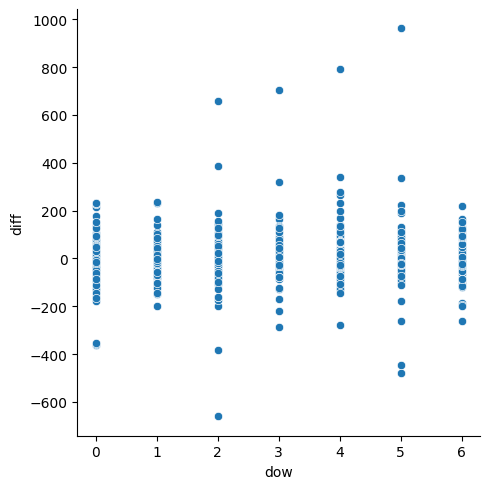

In [7]:
plt.figure(figsize=(15, 6))
sns.relplot(jan_2023, x = "dow", y ="diff")

In [8]:
def compute_runs(df):
    # Initialize lists to store the results
    start_prices = []
    end_prices = []
    run_vectors = []
    run_lengths = []
    start_times = []
    end_times = []
    # Initialize variables to keep track of the current run
    start_price = None
    start_time = None
    current_run_length = 0
    increasing = None  # Track if the run is increasing or decreasing

    # Iterate over the rows in the dataframe
    for i in range(1, len(df)):
        # Calculate daily difference in closing price
        prev_close = df.loc[i-1, 'close']
        current_close = df.loc[i, 'close']
        # Determine if the current row continues the run
        if increasing is None:
            # Set initial direction of the run
            start_price = prev_close
            start_time = df.loc[i-1, 'open_date']
            increasing = current_close > prev_close
            current_run_length = 1
        elif (increasing and current_close > prev_close) or (not increasing and current_close < prev_close):
            # Continue the run
            current_run_length += 1
        else:
            # End of the run, record data
            start_prices.append(start_price)
            end_prices.append(prev_close)
            run_vectors.append(current_run_length if increasing else -current_run_length)
            run_lengths.append(current_run_length)
            start_times.append(start_time)
            end_times.append(df.loc[i-1, 'open_date'])
            
            # Reset run variables for a new run
            start_price = prev_close
            start_time = df.loc[i-1, 'open_date']
            increasing = current_close > prev_close
            current_run_length = 1
    
    # Capture the last run if it reaches the end of the dataset
    start_prices.append(start_price)
    end_prices.append(df.loc[len(df)-1, 'close'])
    run_vectors.append(current_run_length if increasing else -current_run_length)
    run_lengths.append(current_run_length)
    start_times.append(start_time)
    end_times.append(df.loc[len(df)-1, 'open_date'])
    
    # Create the new DataFrame
    result = pd.DataFrame(
        {'start_price': start_prices,
         'end_price': end_prices,
         'run_vector': run_vectors,
         'run_len': run_lengths,
         'start_time': start_times,
         'end_time': end_times})
    result['run_diff'] = result['end_price'] - result['start_price']
    return result

In [9]:
runs_jan_2023 = compute_runs(jan_2023)

In [10]:
runs_jan_2023['run_len'].dtype 

dtype('int64')

In [11]:
def compare_two_variables(df, v1: Variable, v2: Variable):
    # Set the style for Seaborn
    sns.set(style="whitegrid")
    # Plot histograms with kernel density estimation for 'run_len' and 'run_diff'
    plt.figure(figsize=(14, 6))
    
    def plot_categorical(variable: Variable, color = None):        
        sns.countplot(df, x=variable.column, color=color)
        plt.title('Histogram of %s with Kernel Density' % variable.label)
        plt.xlabel(variable.label)
        plt.ylabel('Frequency')
    
    def plot_continuous(variable: Variable, color=None):
        sns.histplot(df[variable.column], kde=True, color=color, bins=20)
        plt.title('Histogram of %s with Kernel Density' % variable.label)
        plt.xlabel(variable.label)
        plt.ylabel('Frequency')
    
    def plot(variable: Variable, color=None):
        if variable.type == "categorical":
            plot_categorical(variable, color)
        else:
            plot_continuous(variable, color)
    plt.subplot(1, 2, 1)    
    plot(v1, color=None)
    plt.subplot(1, 2, 2)
    plot(v2, color="salmon")

    plt.tight_layout()
    plt.show()
    
    # Scatter plot of run_len vs run_diff
    plt.figure(figsize=(8, 6))
    if v1.type == "categorical" and v2.type != "categorical":
        # sns.boxplot(x=v1.column, y=v2.column, data=df, color="purple", s=60, alpha=0.7)
        ax = sns.boxplot(x=df[v1.column], y=df[v2.column], native_scale=True)
        ax.axvline(10, color=".3", dashes=(2, 2))

    else:
        sns.scatterplot(x=v1.column, y=v2.column, data=df, color="purple", s=60, alpha=0.7)
    
    # sns.scatterplot(x=v1.column, y=v2.column, data=df, color="purple", s=60, alpha=0.7)
    
    plt.title('Scatter Plot of %s vs %s' % (v1.label, v2.label))
    plt.xlabel(v1.label)
    plt.ylabel(v2.label)
    plt.show()    

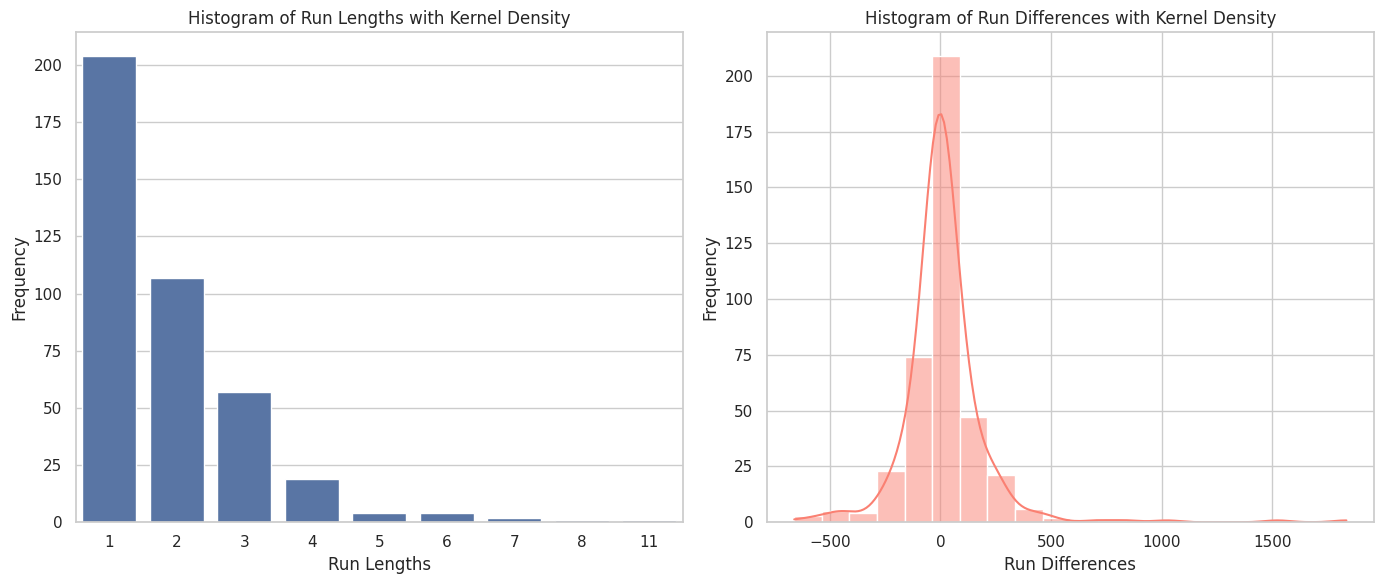

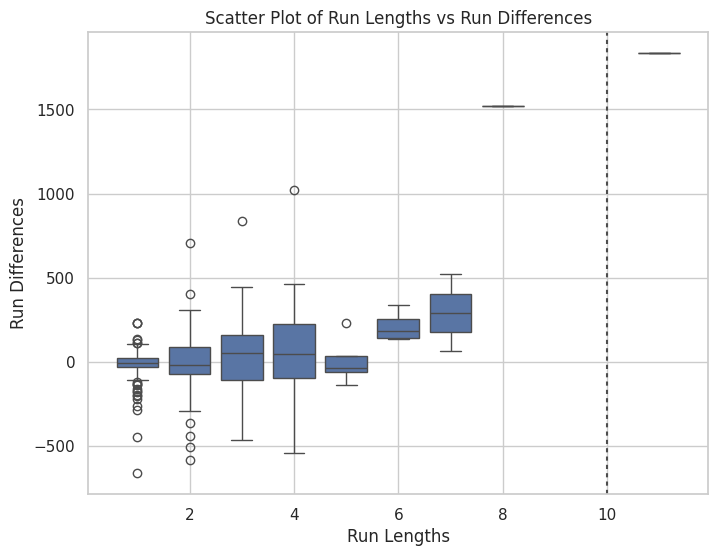

In [12]:

run_len = Variable(column='run_len', label='Run Lengths', type='categorical')
run_diff = Variable(column='run_diff', label='Run Differences', type='int')
compare_two_variables(runs_jan_2023, run_len, run_diff)

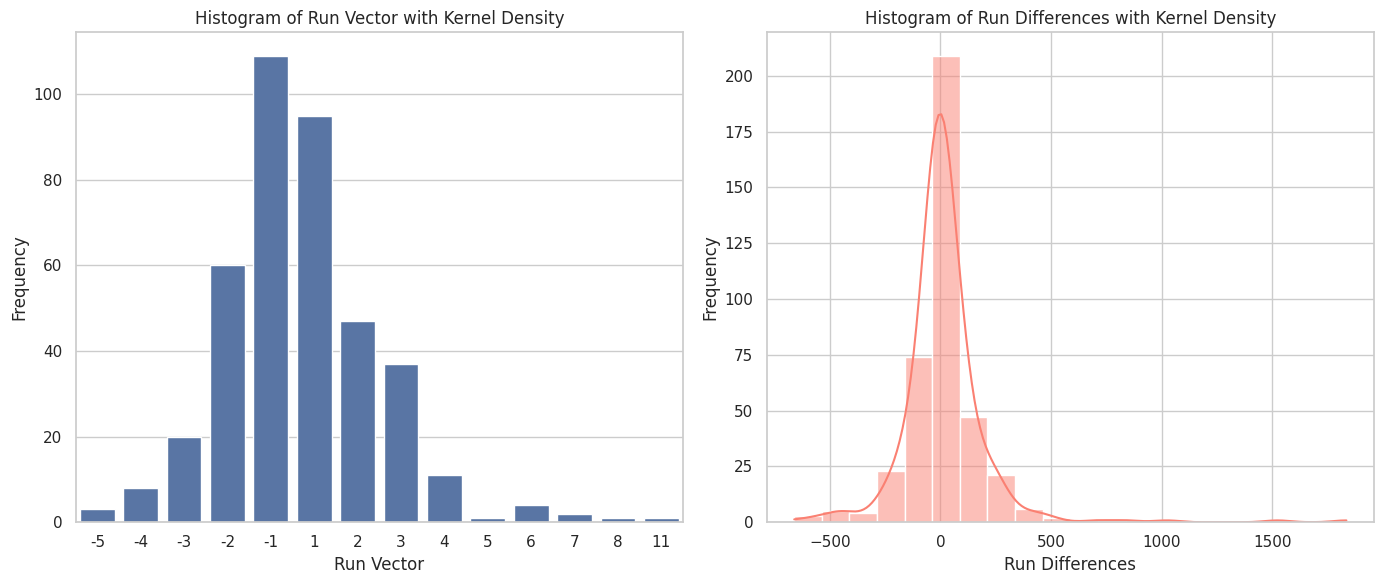

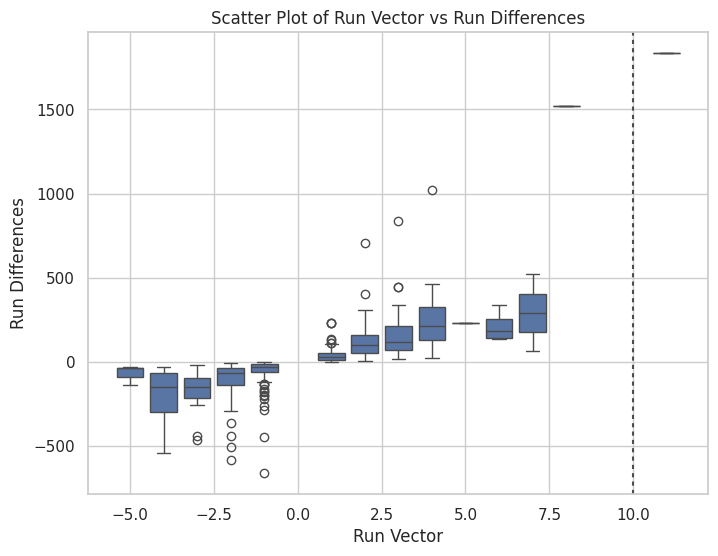

In [13]:
run_vector = Variable(column='run_vector', label='Run Vector', type='categorical')
run_diff = Variable(column='run_diff', label='Run Differences', type='int')
compare_two_variables(runs_jan_2023, run_vector, run_diff)


In [14]:
def compute_stats(result_df):
    # Calculate statistics for 'run_len'
    run_len_mean = result_df['run_len'].mean()
    run_len_std = result_df['run_len'].std()
    run_len_kurtosis = kurtosis(result_df['run_len'])
    run_len_skew = skew(result_df['run_len'])
    
    # Calculate statistics for 'run_diff'
    run_diff_kurtosis, run_diff_mean, run_diff_skew, run_diff_std = compuse_stats_of_column(result_df['run_diff'])

    # Display the results
    stats = pd.DataFrame({
        'Statistic': ['Mean', 'Standard Deviation', 'Kurtosis', 'Skew'],
        'Run Length': [run_len_mean, run_len_std, run_len_kurtosis, run_len_skew],
        'Run Difference': [run_diff_mean, run_diff_std, run_diff_kurtosis, run_diff_skew]
    })
    return stats


def compuse_stats_of_column(df_col):
    col_mean = df_col.mean()
    col_std = df_col.std()
    col_kurtosis = kurtosis(df_col)
    col_skew = skew(df_col)
    return col_kurtosis, col_mean, col_skew, col_std

In [15]:

compute_stats(runs_jan_2023)

,Statistic,Run Length,Run Difference
0,Mean,1.859649,16.475338
1,Standard Deviation,1.223863,199.338129
2,Kurtosis,10.437924,27.169211
3,Skew,2.492331,3.317489


In [16]:
def compute_daily_volatility_and_return(df):
    # Convert 'open_date' to date format only to group by day
    df['date'] = pd.to_datetime(df['open_date']).dt.date
    
    # Step 1: Calculate hourly returns
    df['hourly_return'] = df['close'].pct_change()
    
    # Step 2: Aggregate hourly returns into daily returns and daily volatility
    # Group by 'date' to compute daily cumulative return and daily volatility
    return df.groupby('date').agg(
        daily_return=('hourly_return', lambda x: (1 + x).prod() - 1),
        daily_volatility=('hourly_return', 'std')
    ).reset_index()
daily_vol_jan_2023 = compute_daily_volatility_and_return(jan_2023)

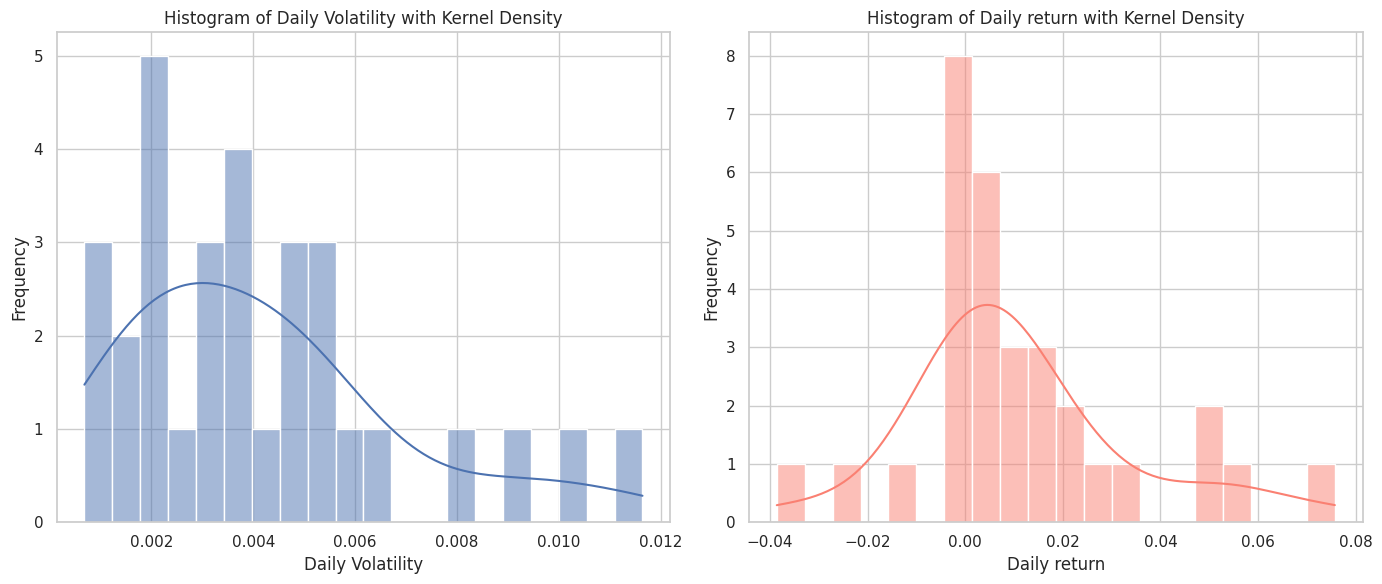

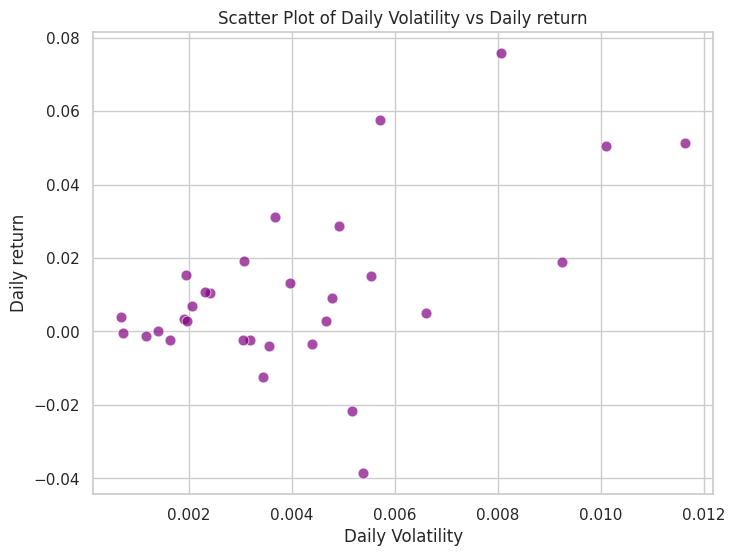

In [17]:
daily_return = Variable(column='daily_return', label='Daily return', type='int')
daily_vol = Variable(column='daily_volatility', label='Daily Volatility', type='int')
compare_two_variables(daily_vol_jan_2023, daily_vol, daily_return)

# Compare all months 

2023 1


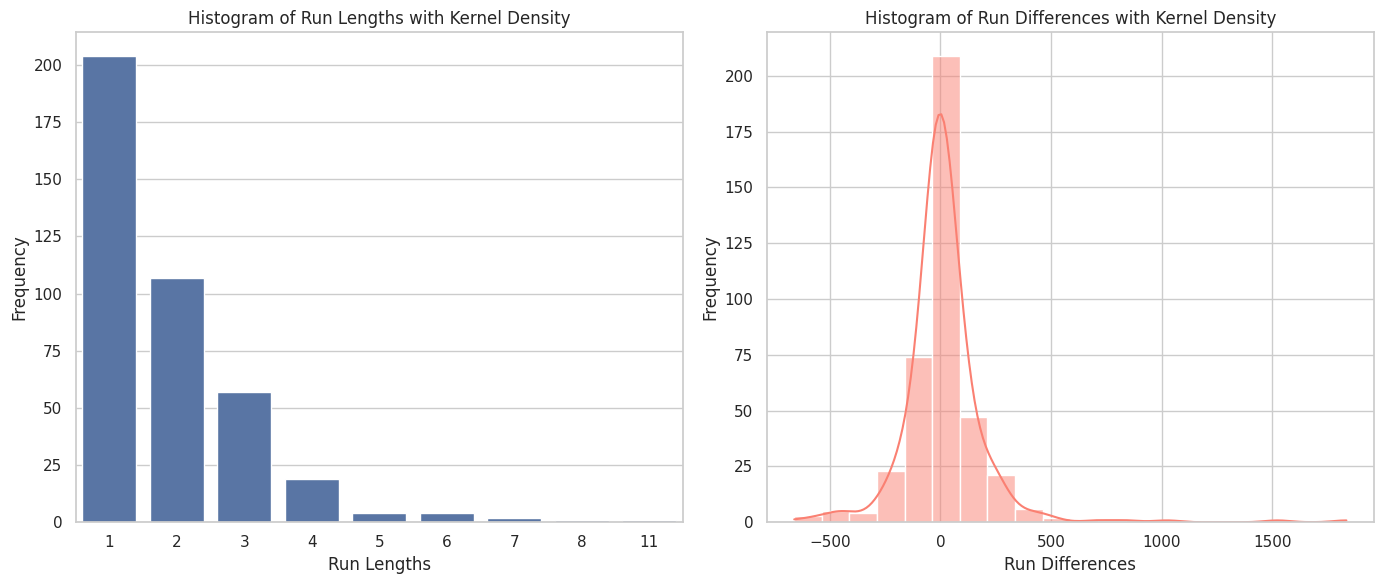

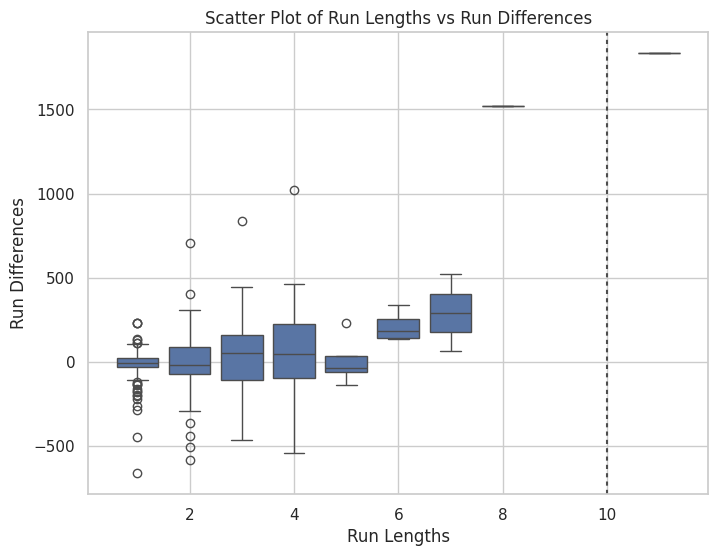

2023 2


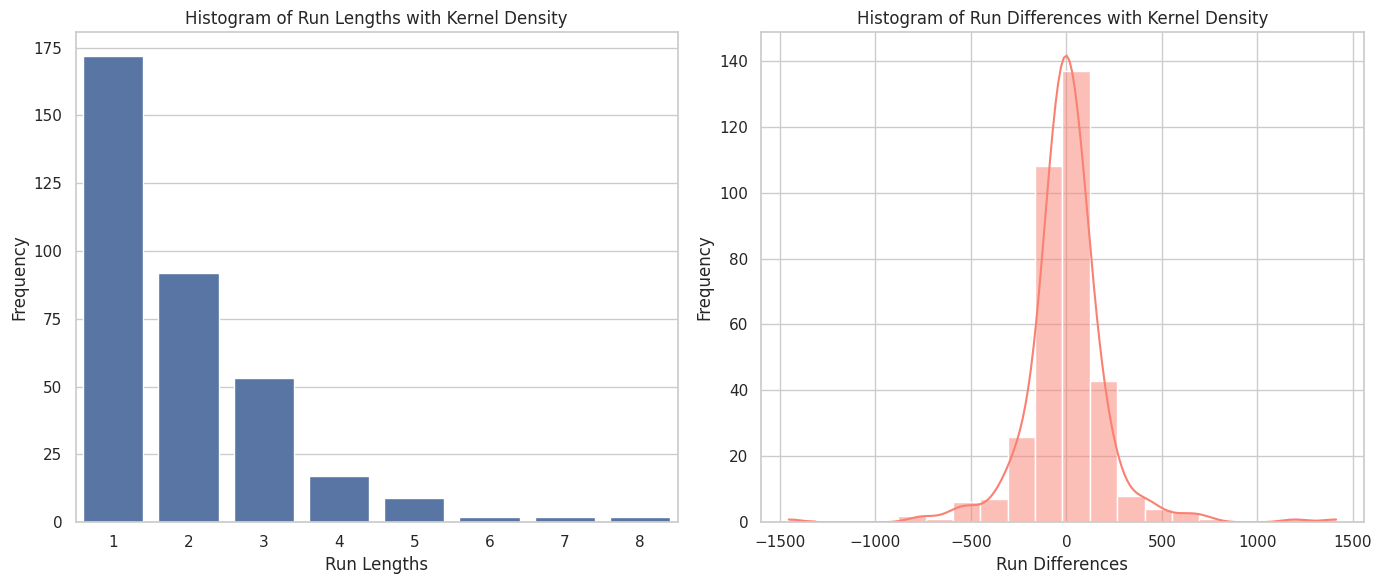

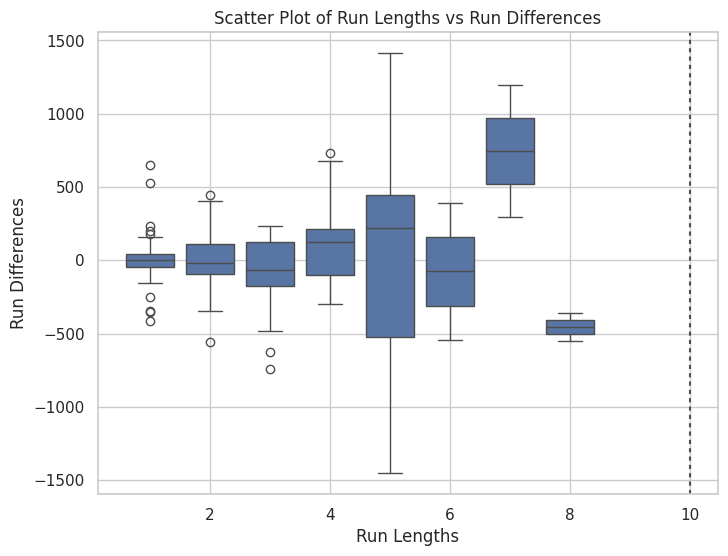

2023 3


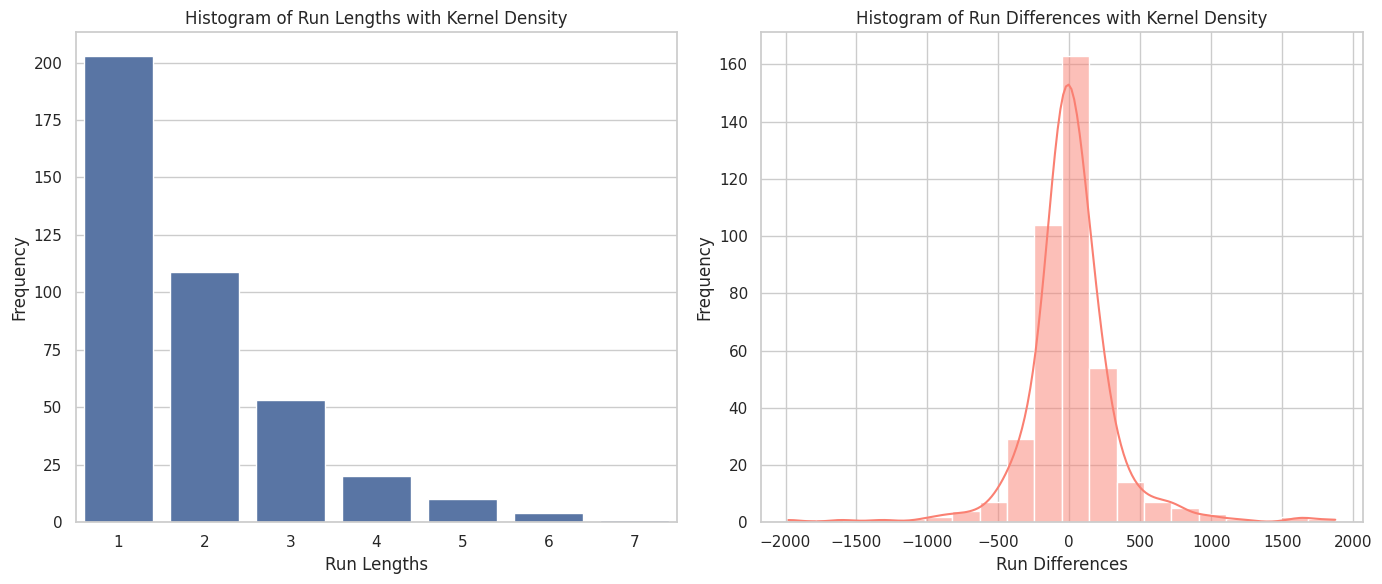

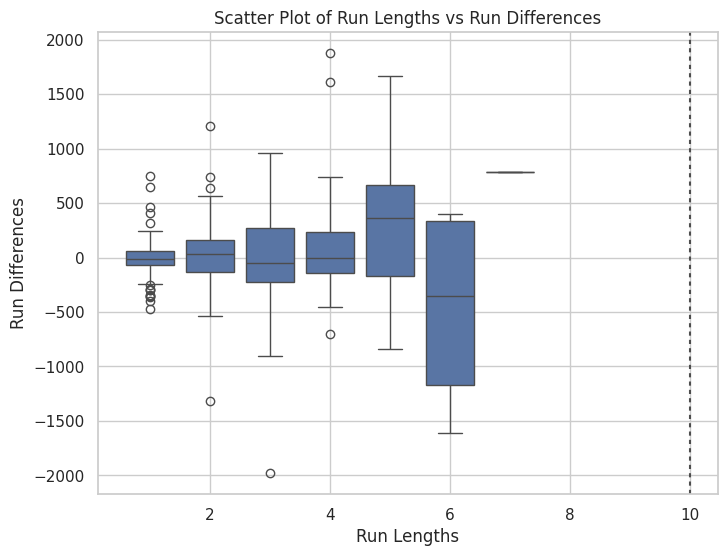

2023 4


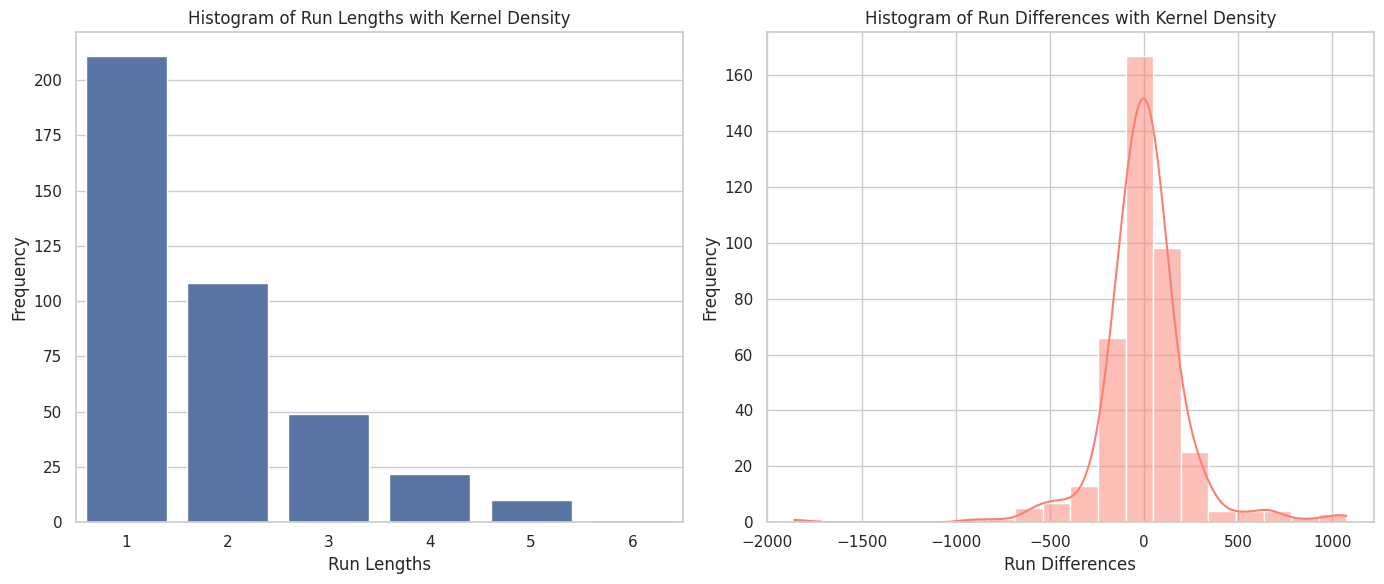

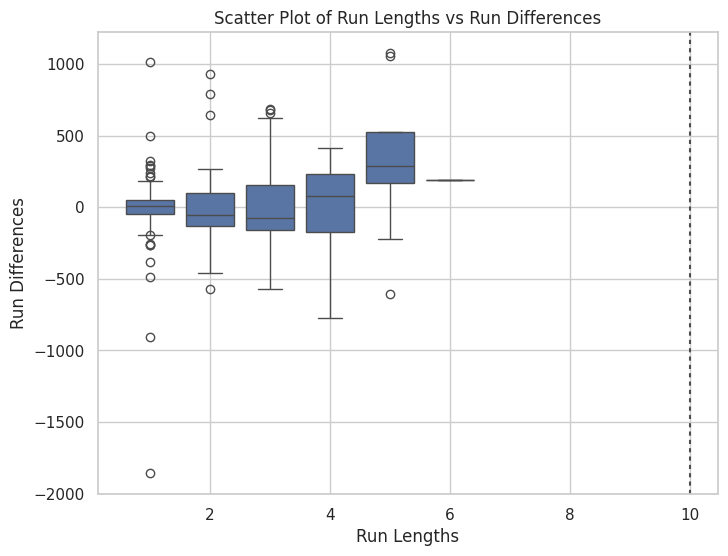

2023 5


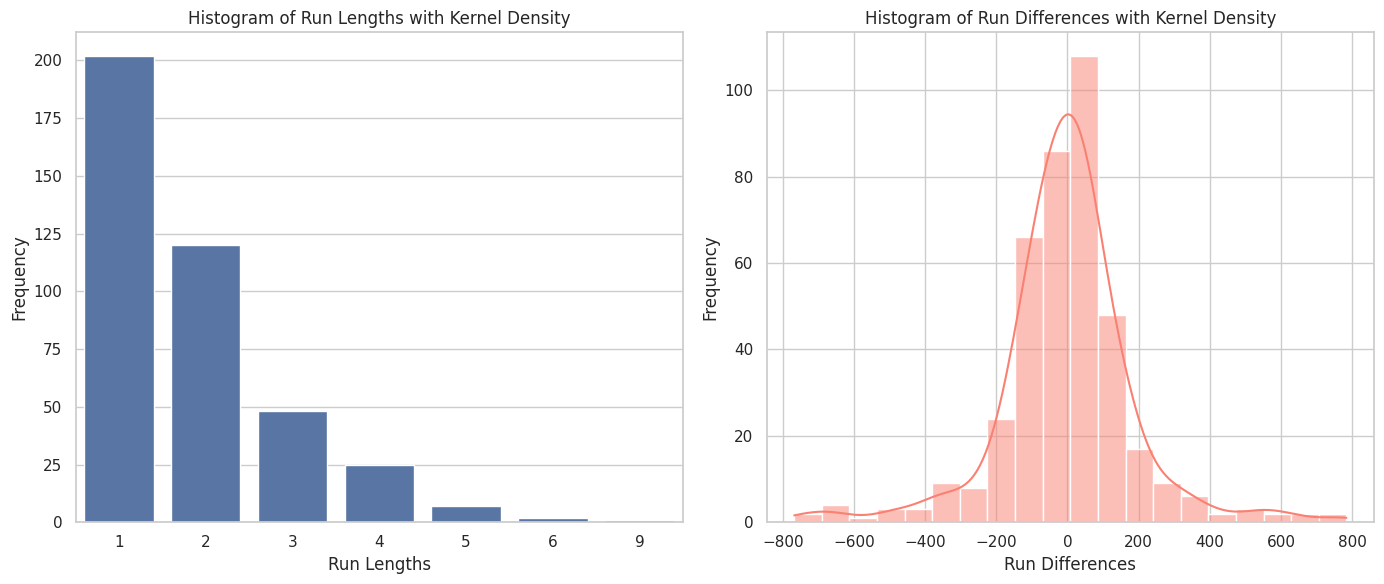

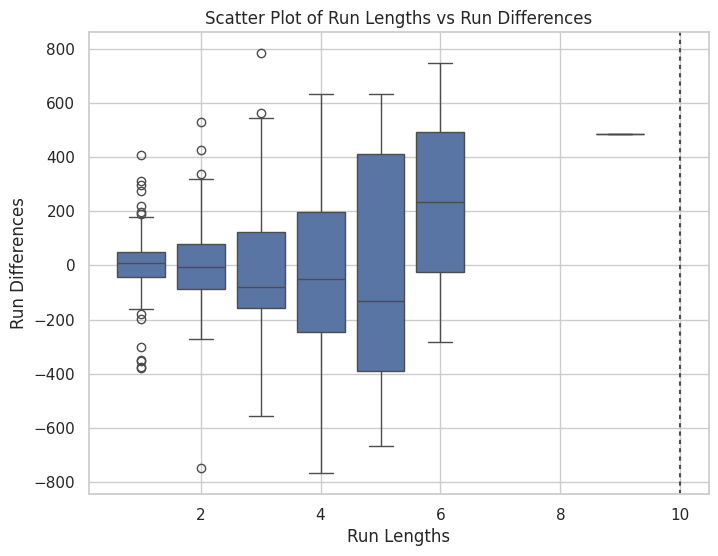

2023 6


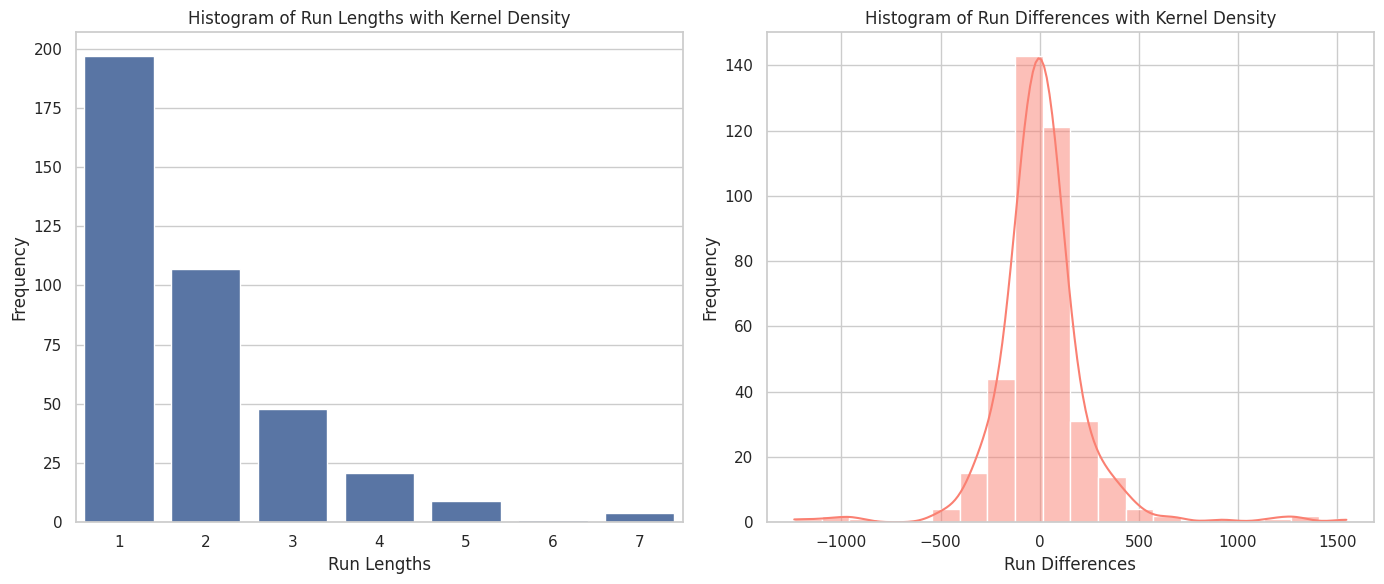

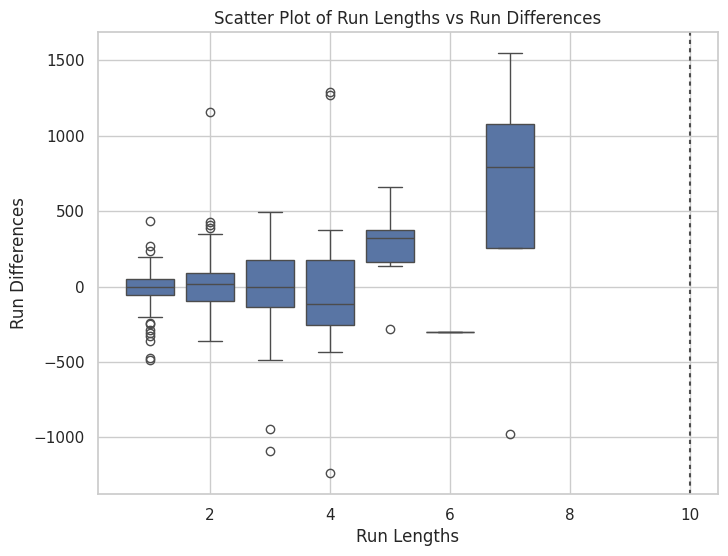

2023 7


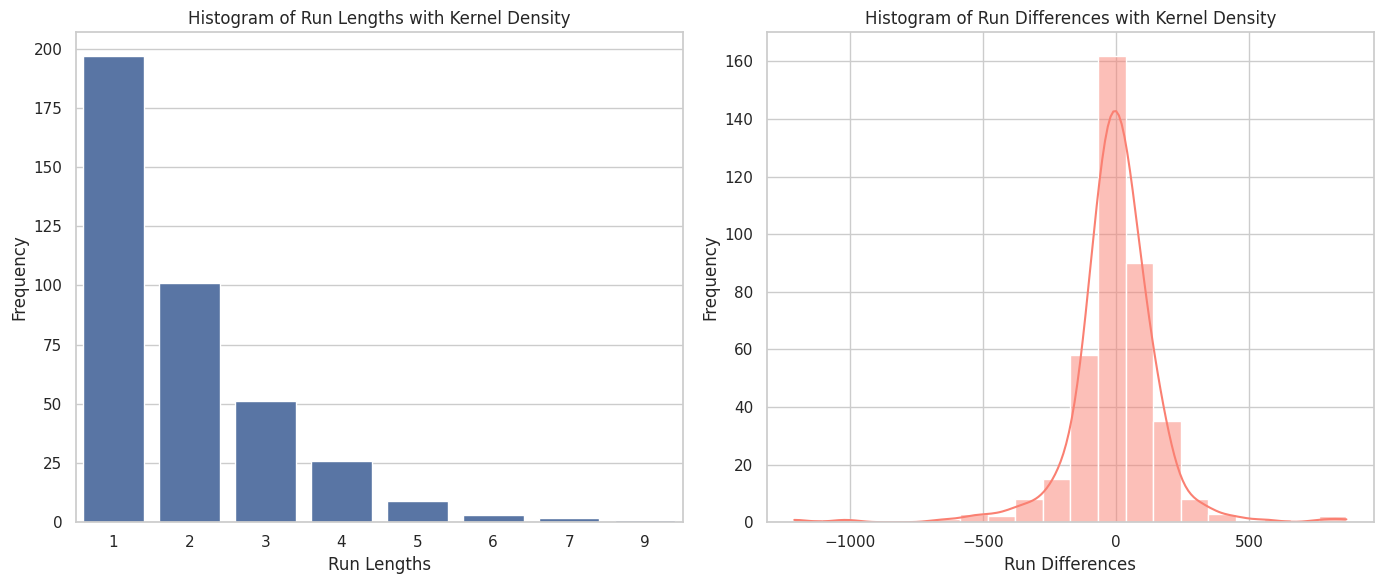

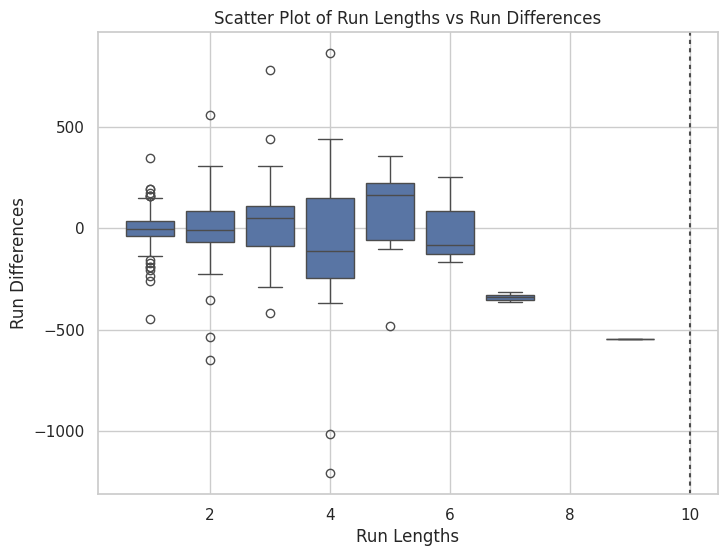

2023 8


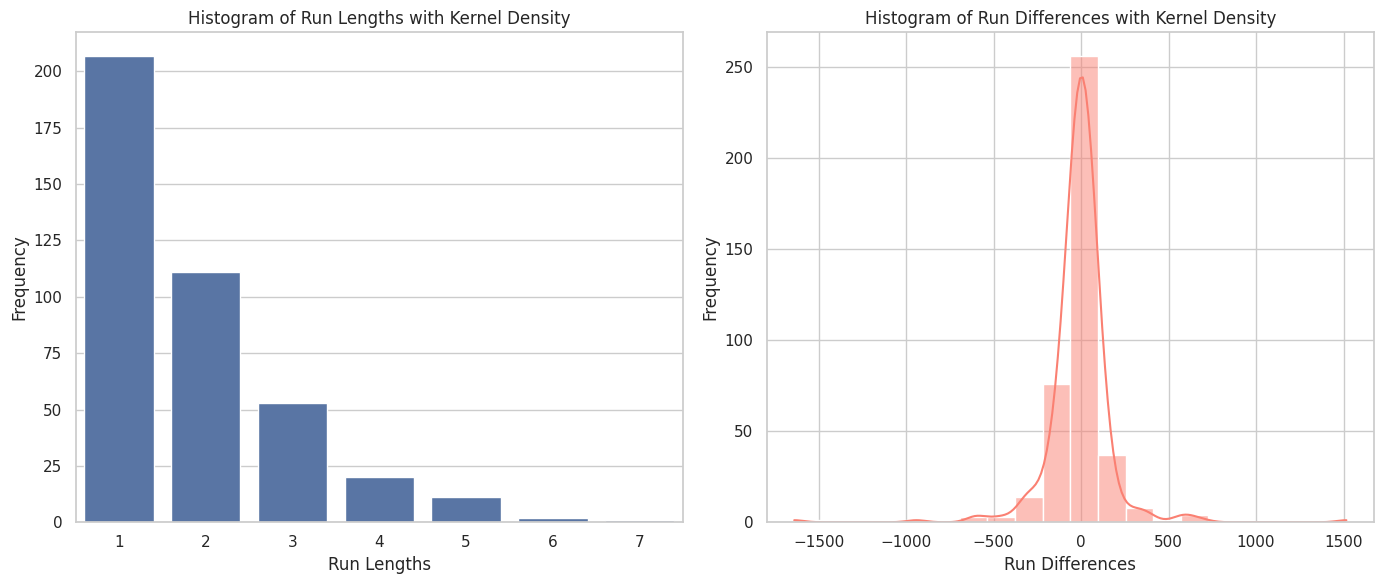

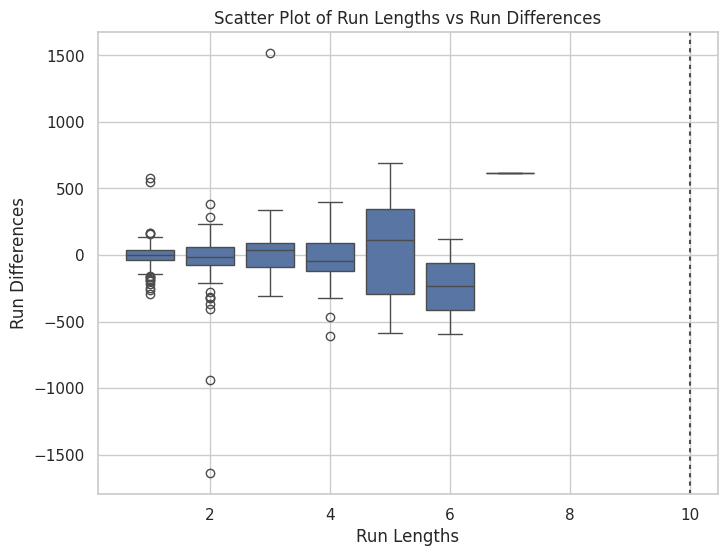

2023 9


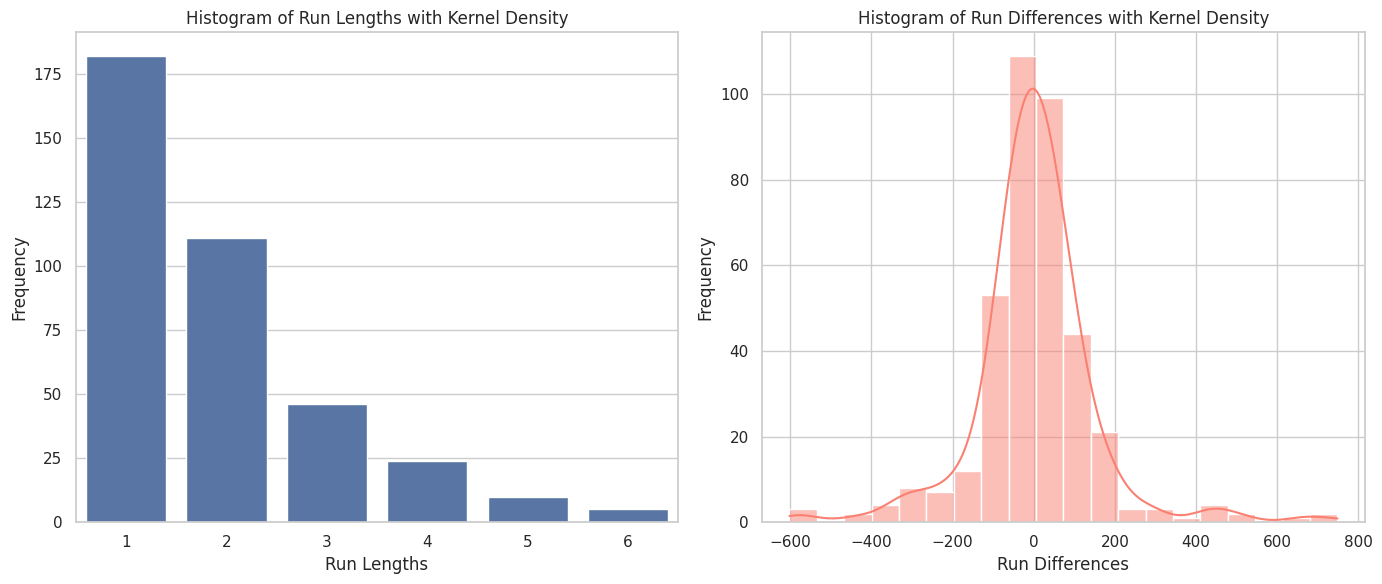

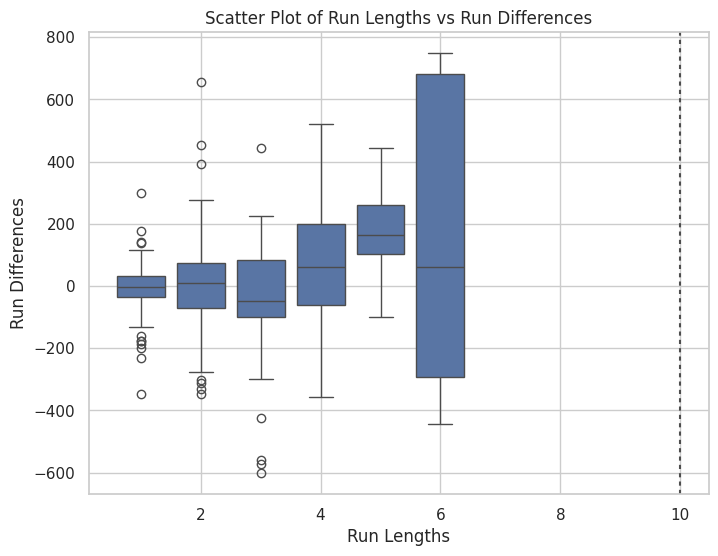

2023 10


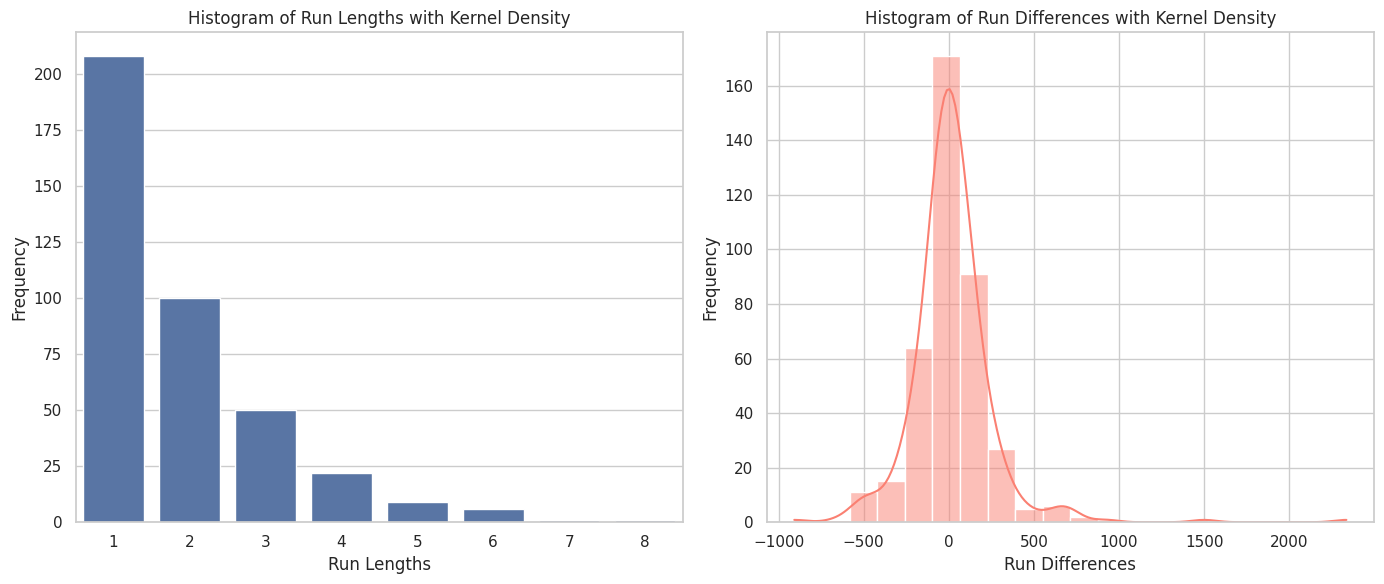

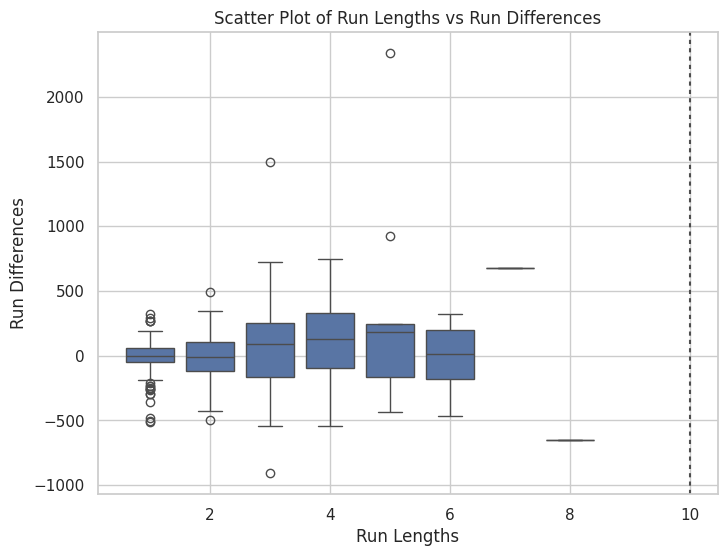

2023 11


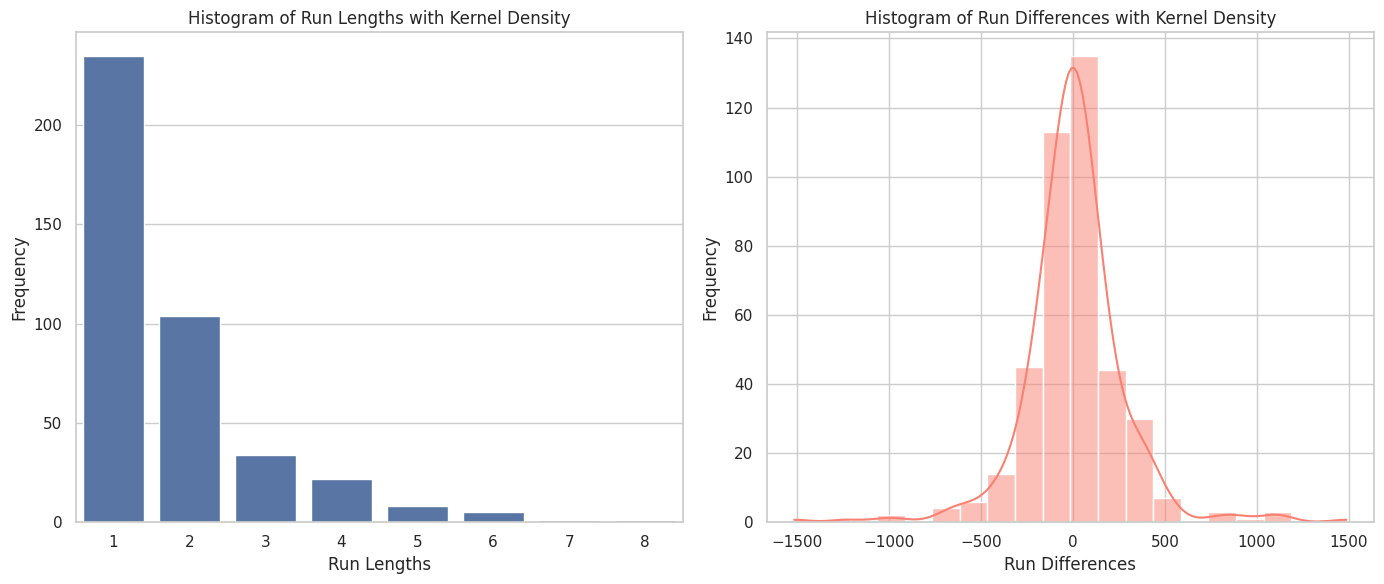

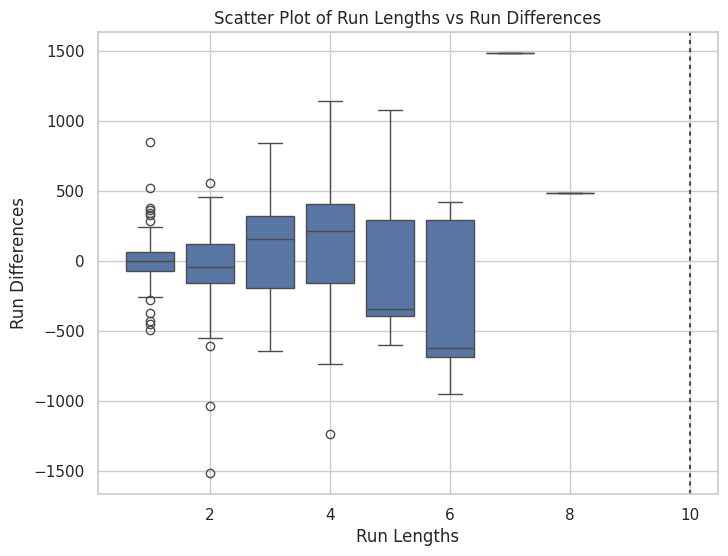

2023 12


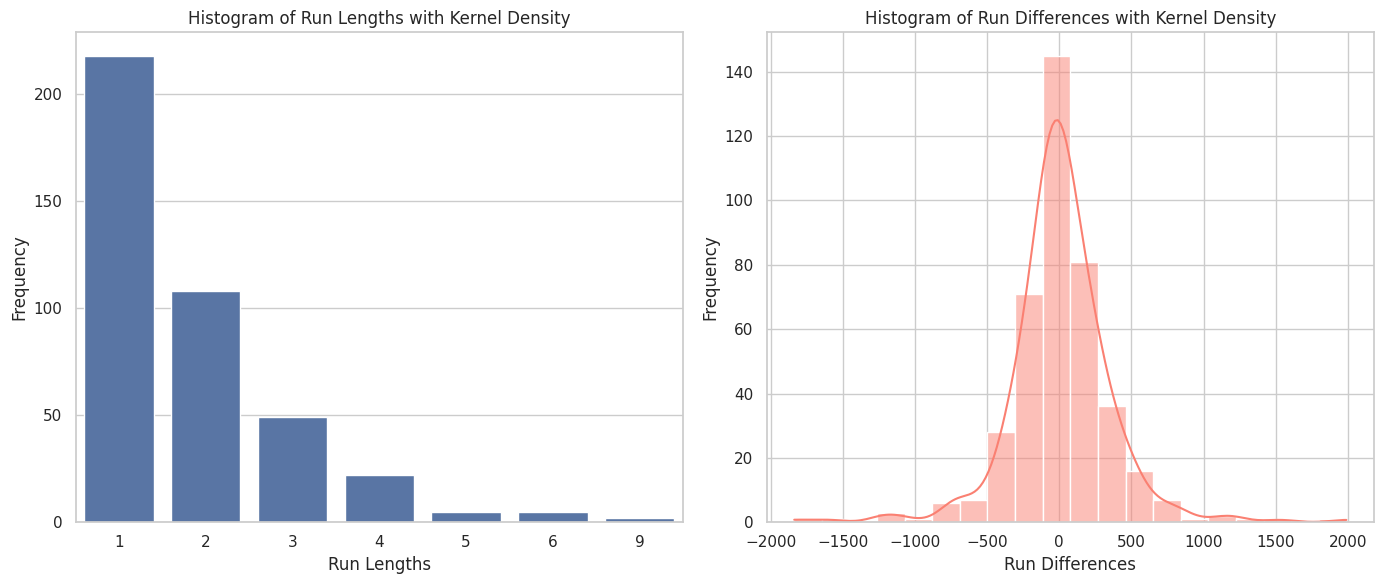

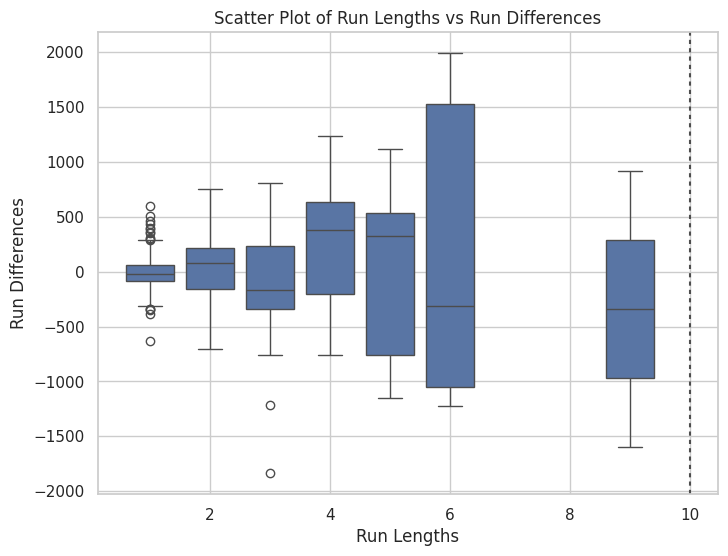

In [18]:
for year, months in values.items():
    for month_name, month in months.items():
        print(year, month_name)
        run_len = Variable(column='run_len', label='Run Lengths', type='categorical')
        run_diff = Variable(column='run_diff', label='Run Differences', type='int')
        compare_two_variables(compute_runs(month), run_len, run_diff)

2023 1


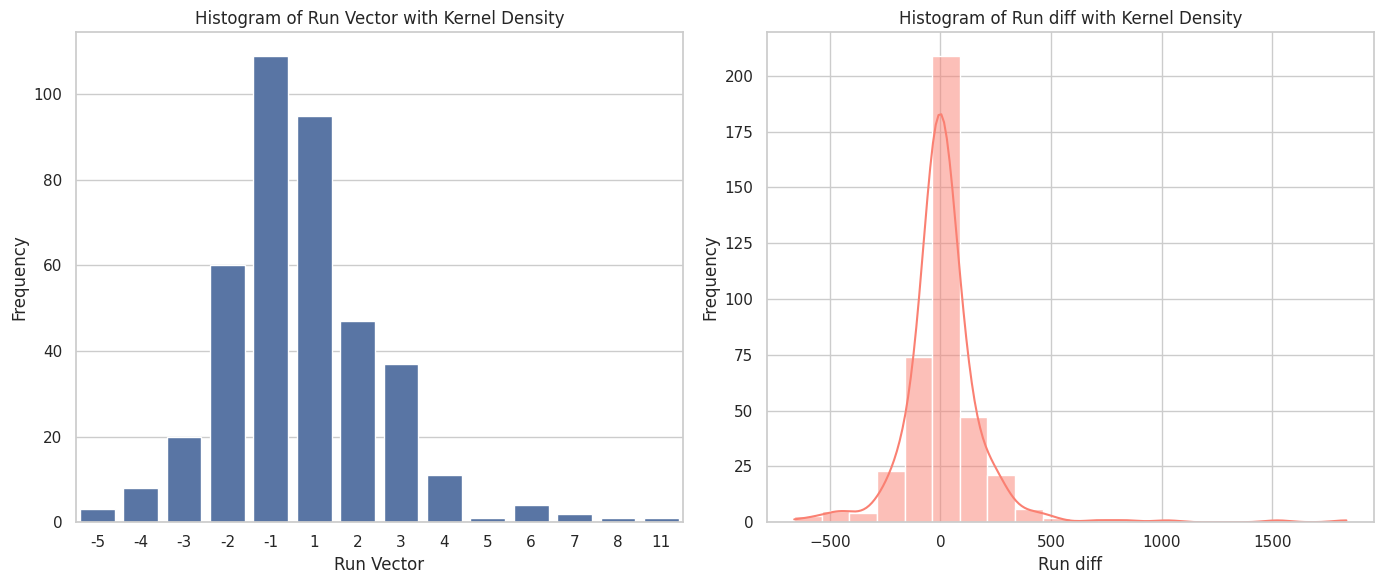

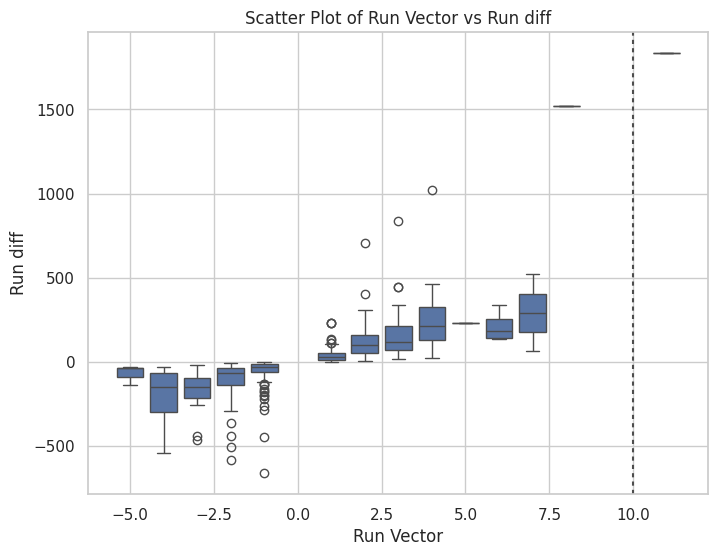

2023 2


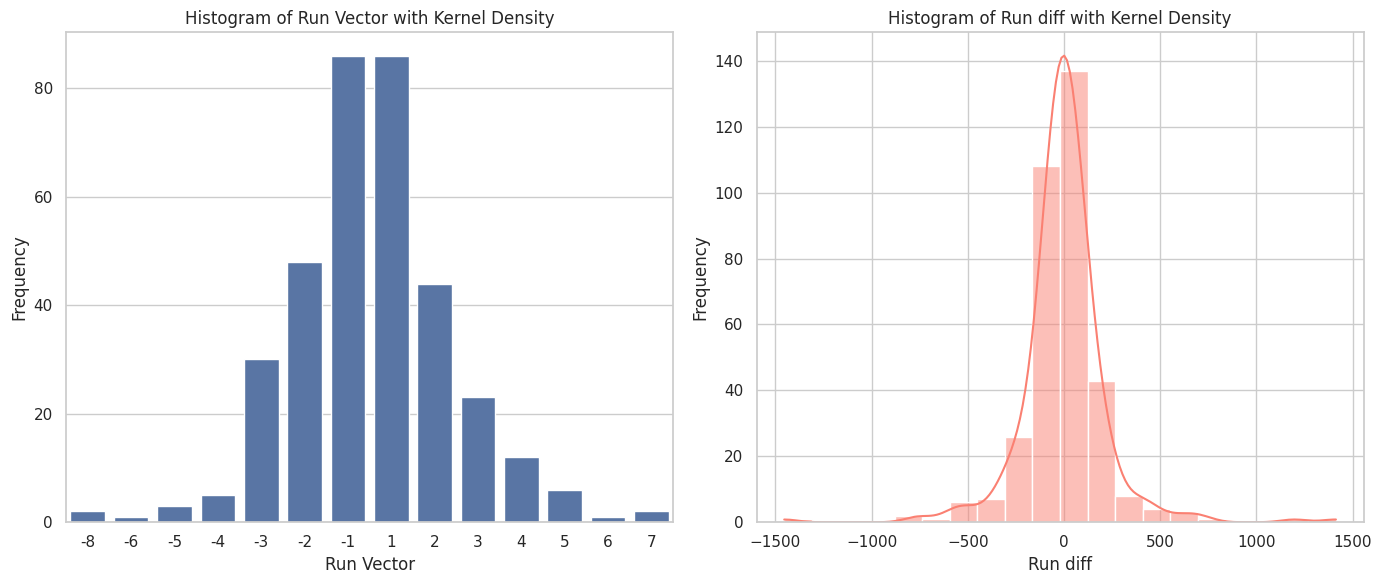

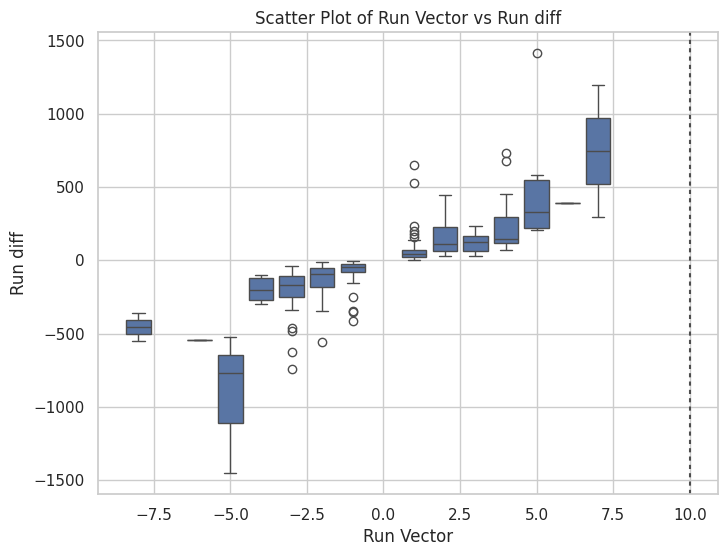

2023 3


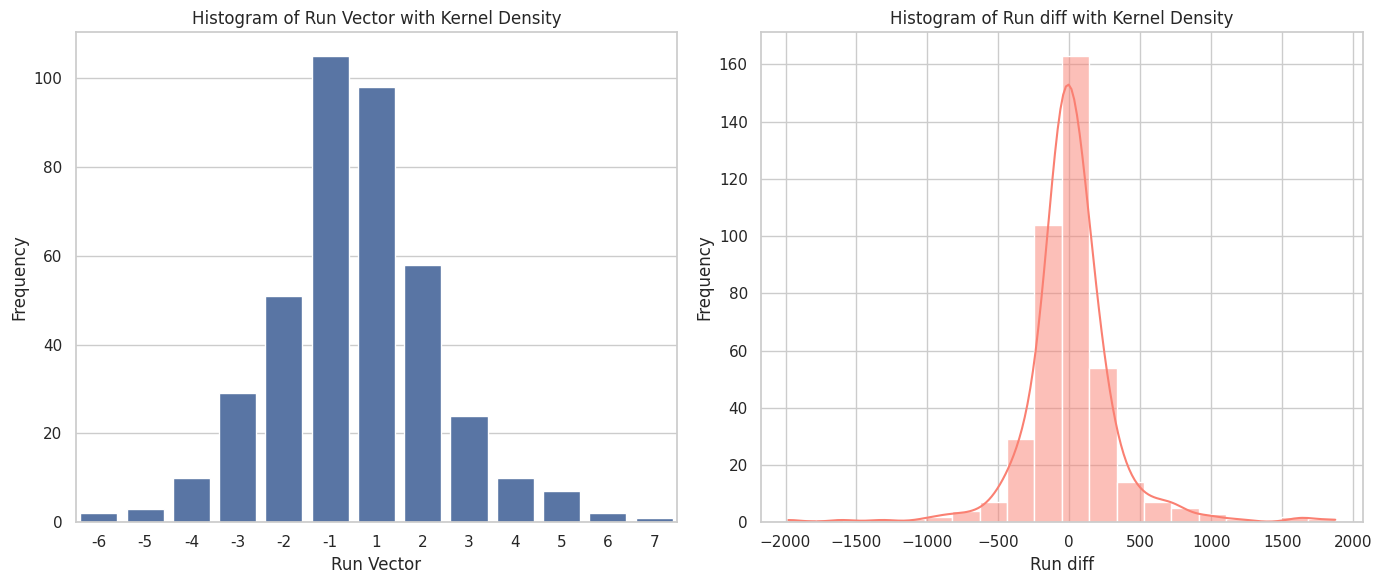

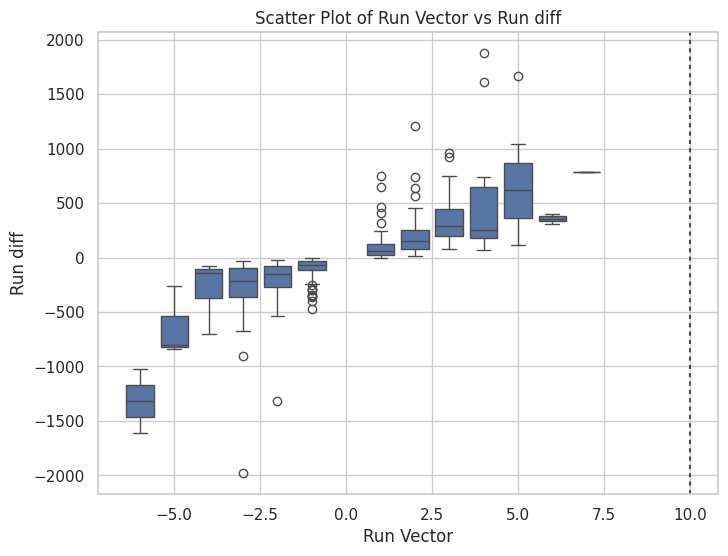

2023 4


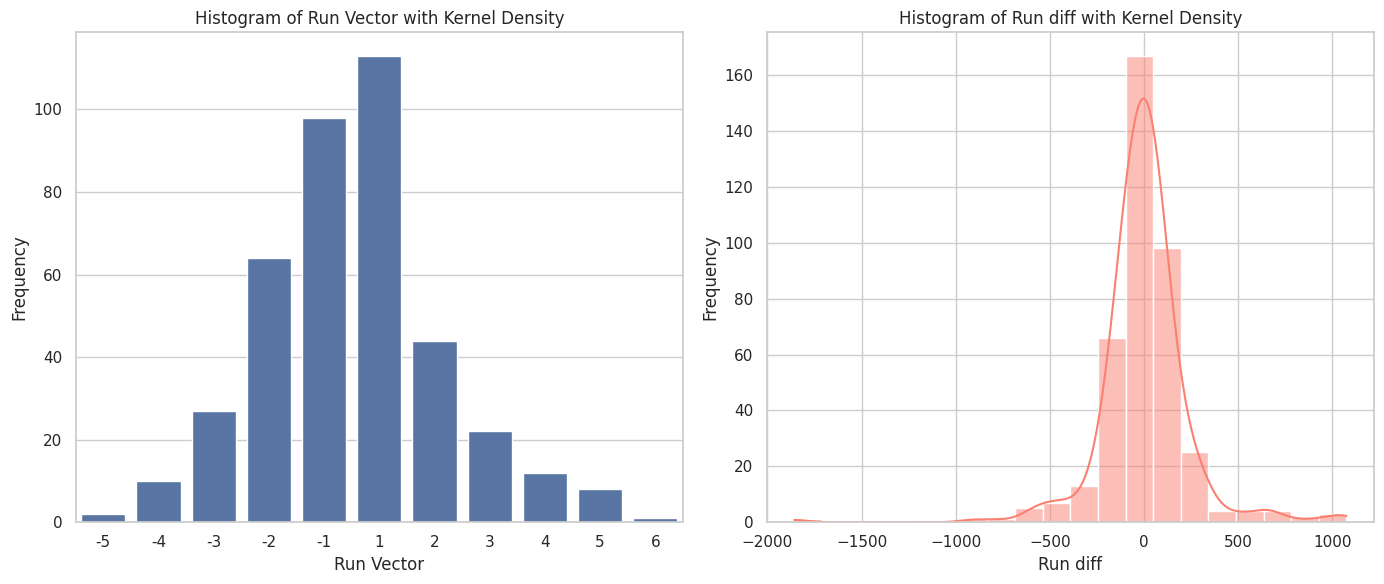

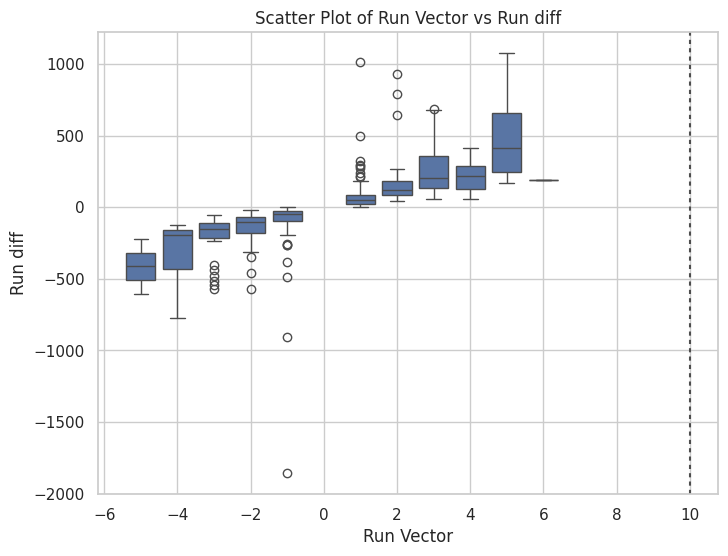

2023 5


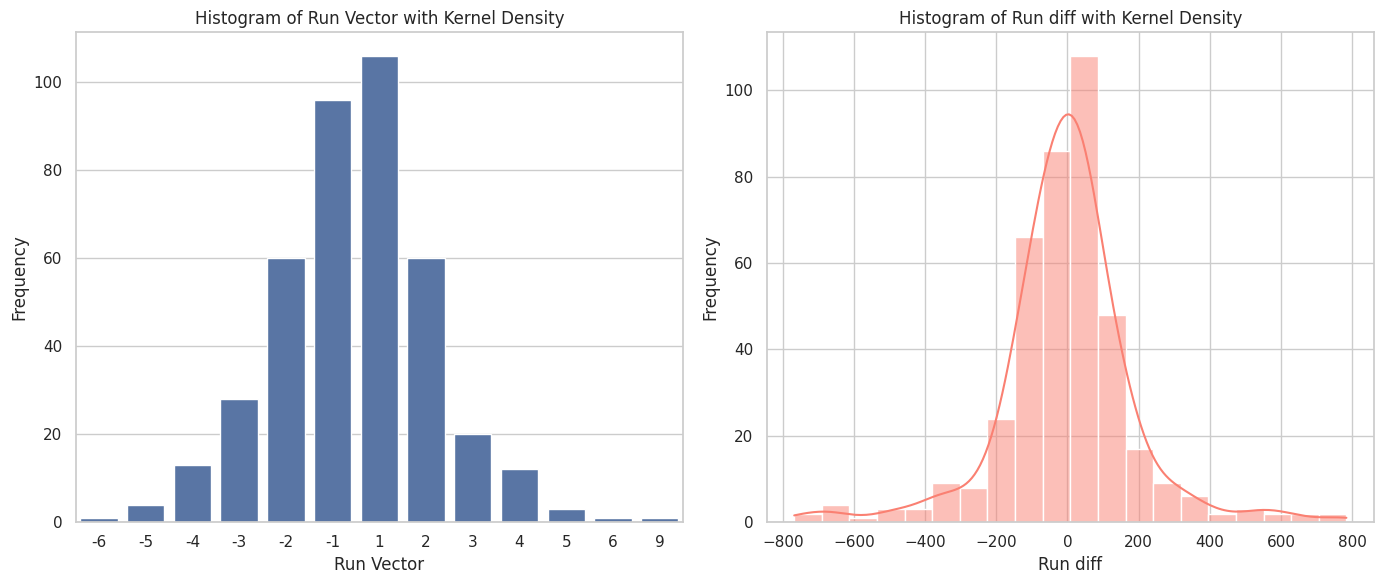

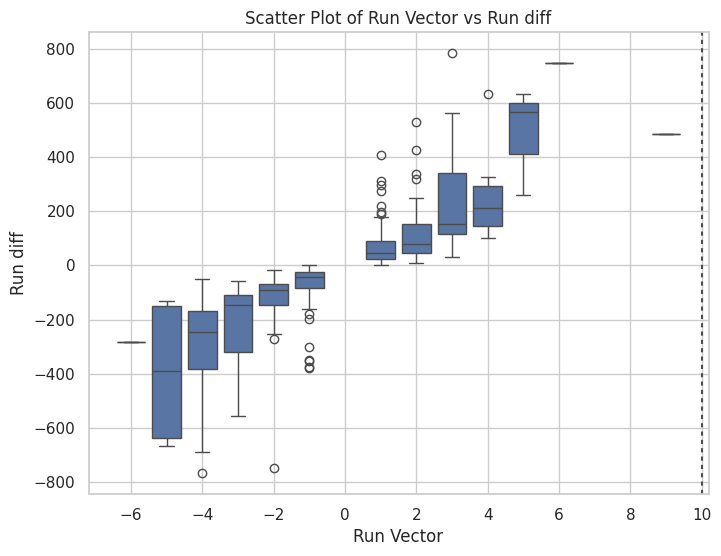

2023 6


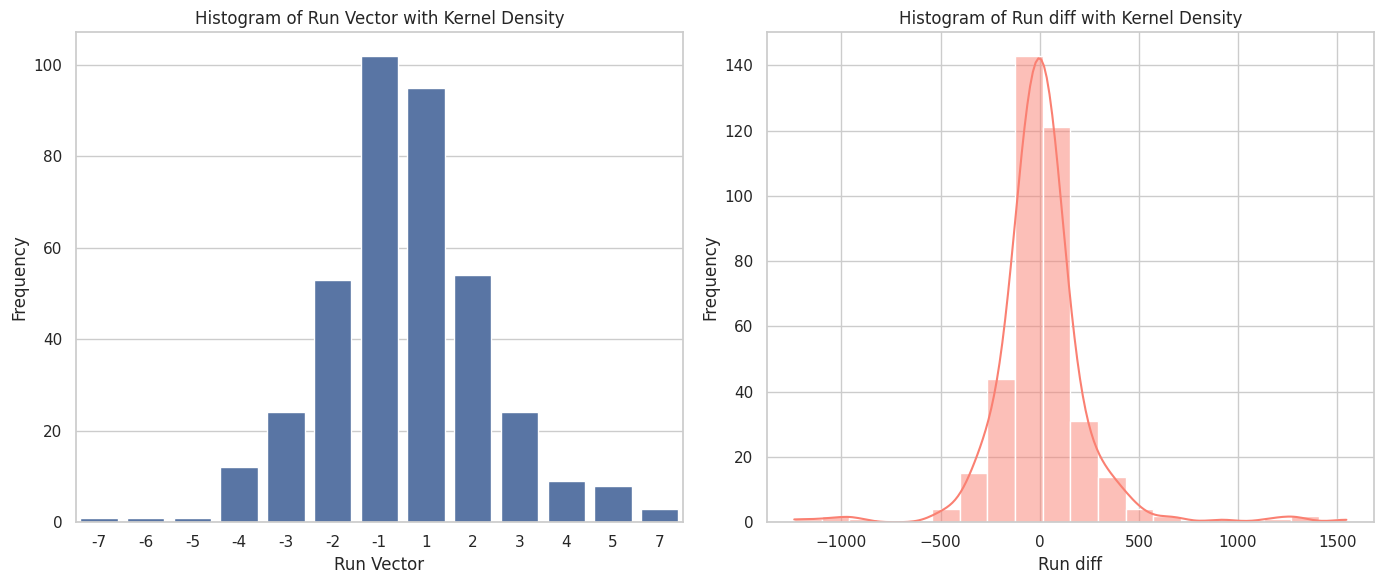

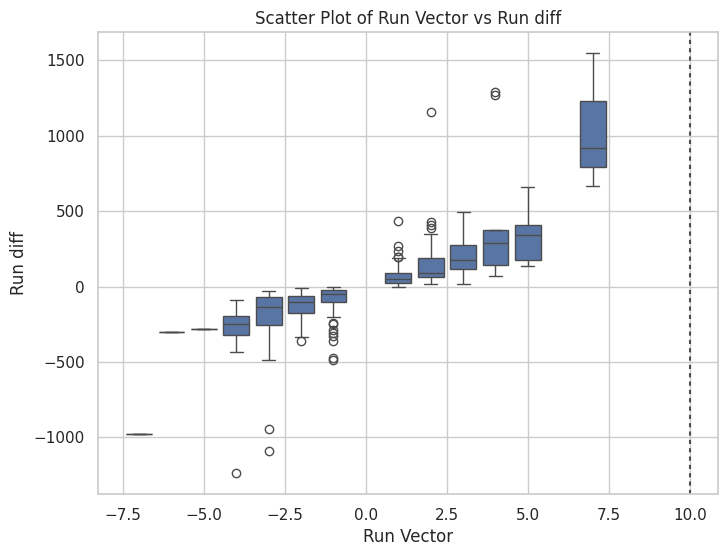

2023 7


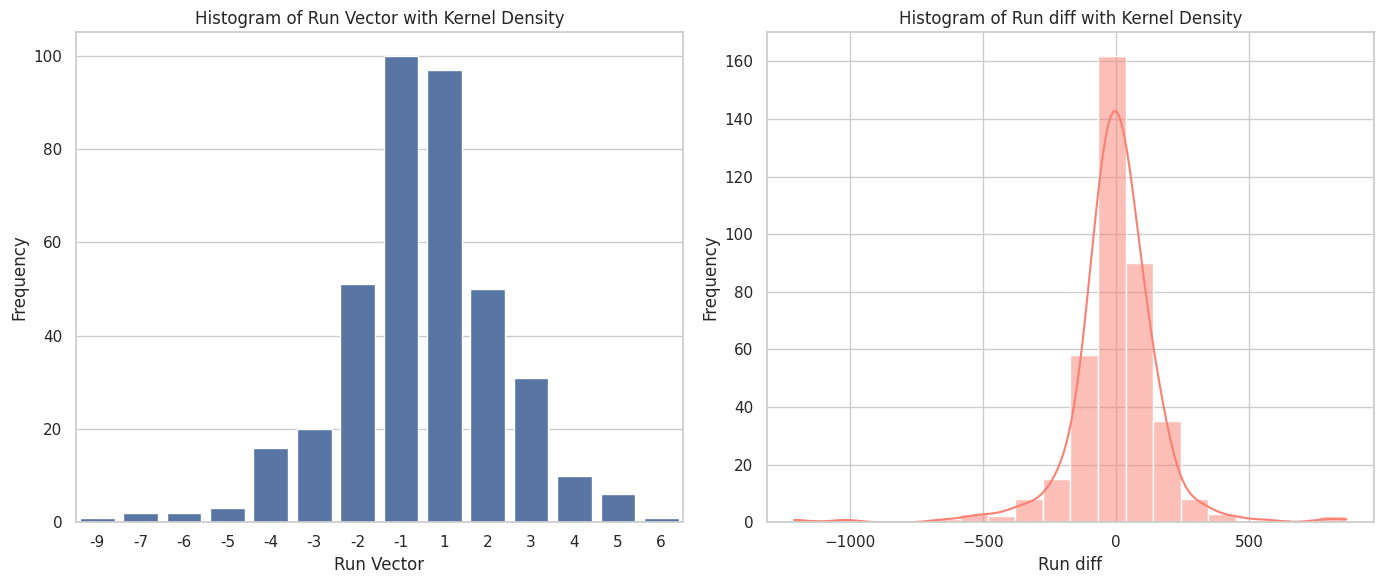

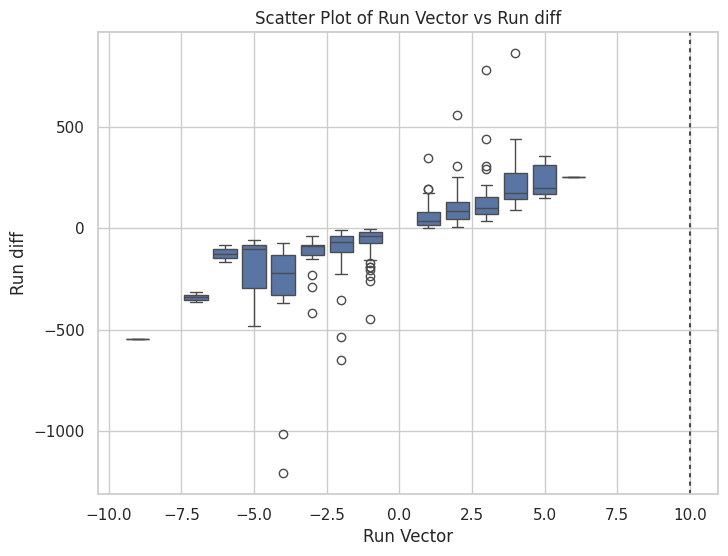

2023 8


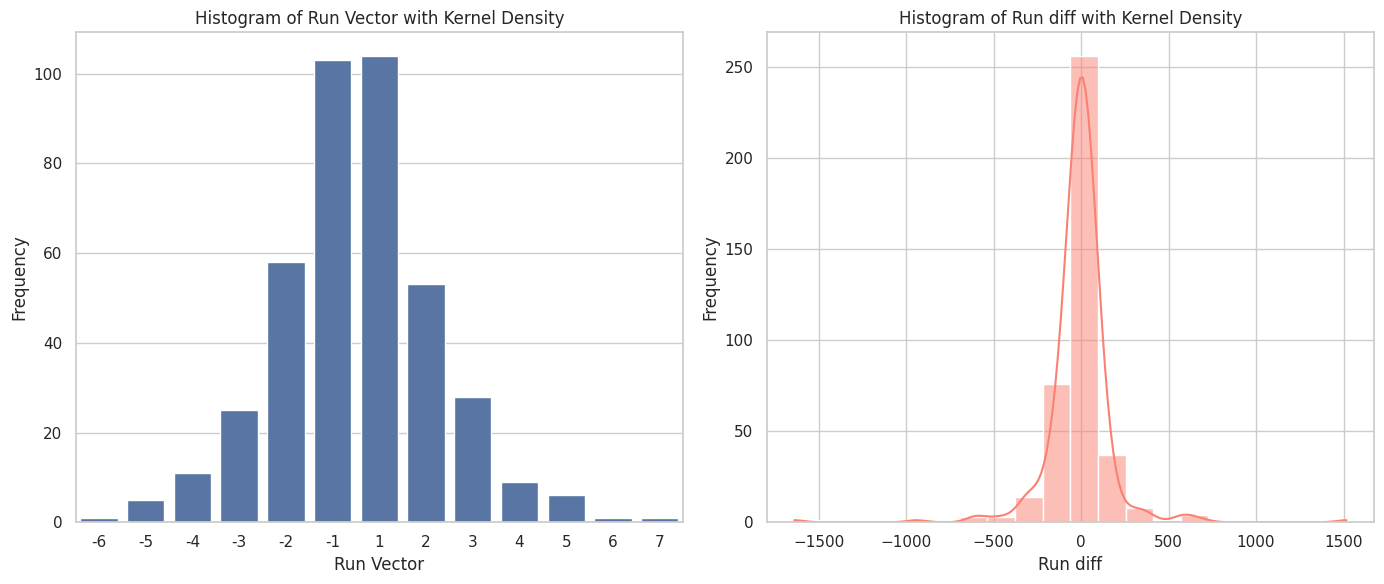

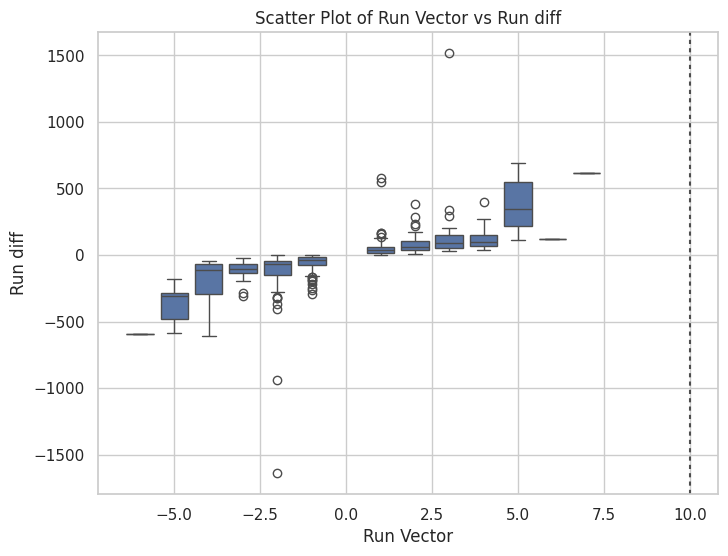

2023 9


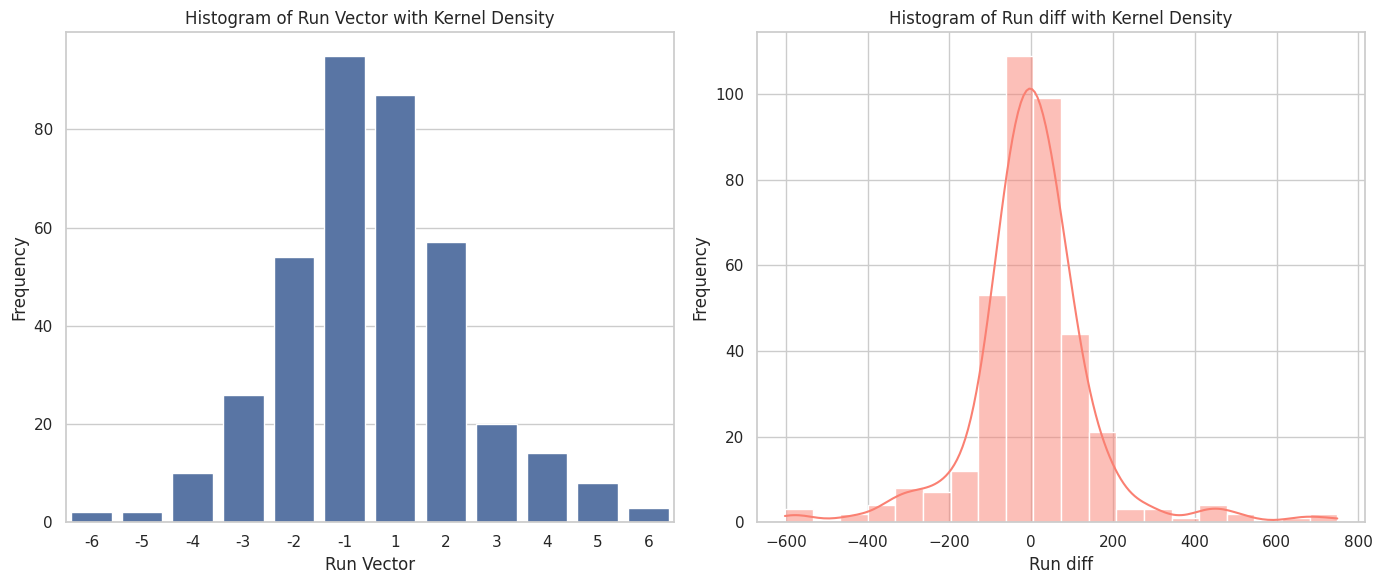

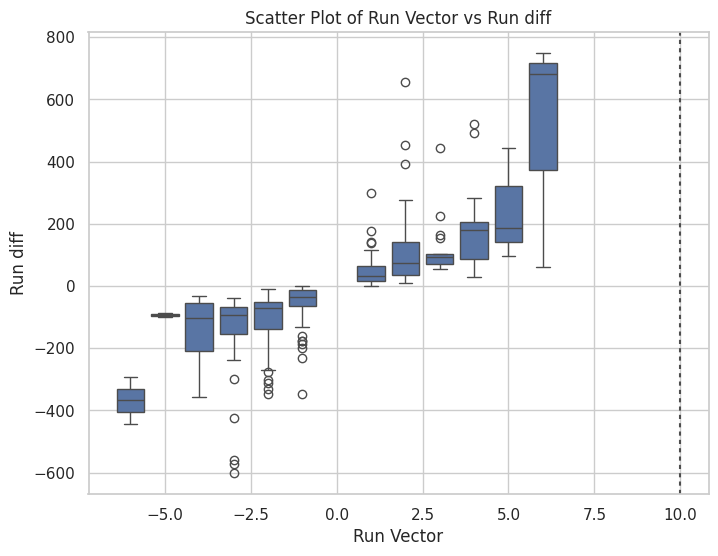

2023 10


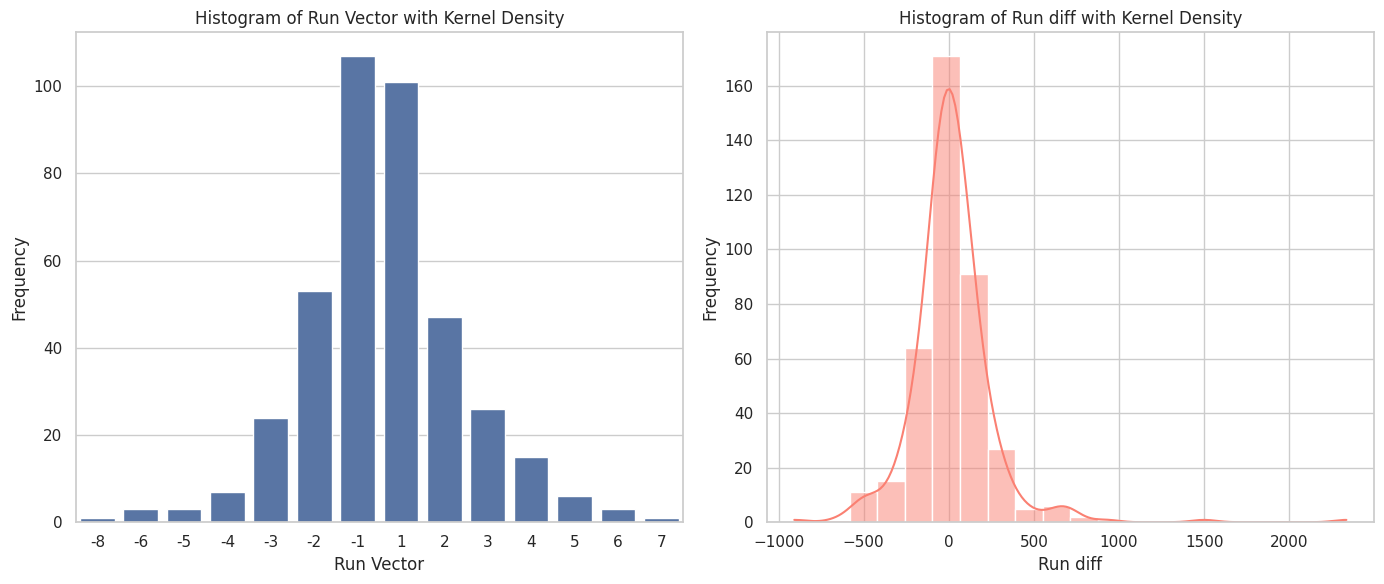

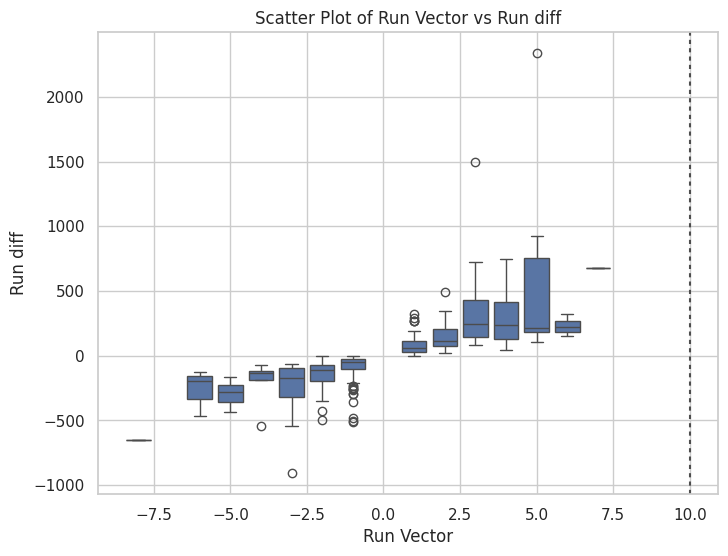

2023 11


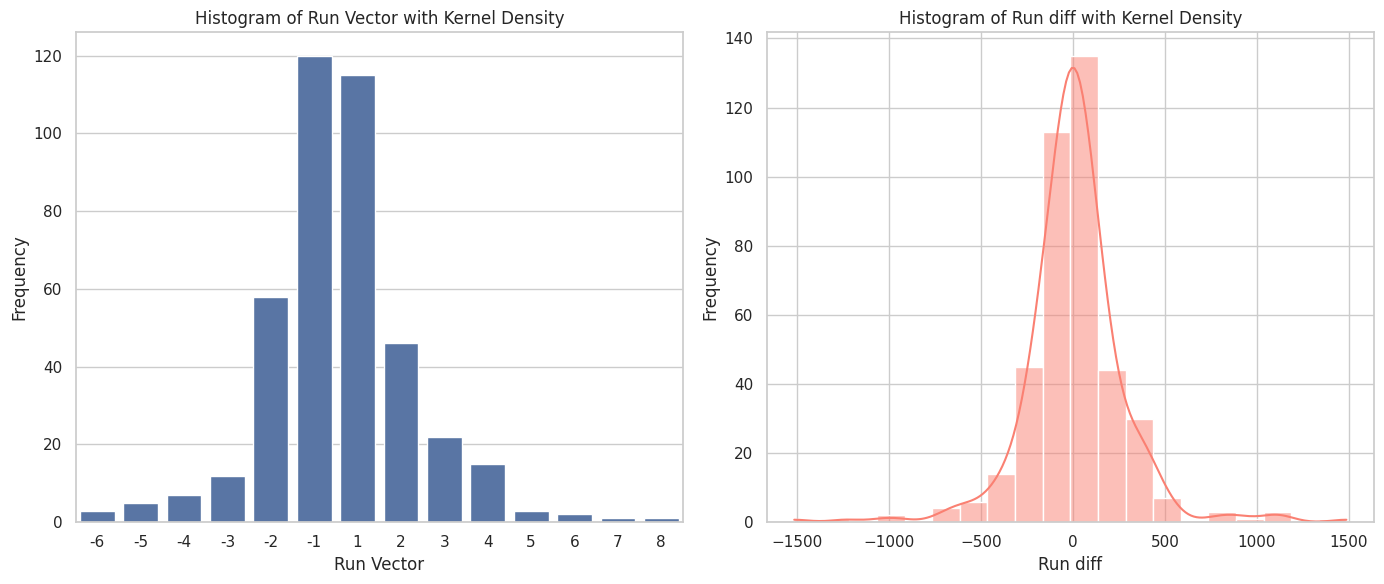

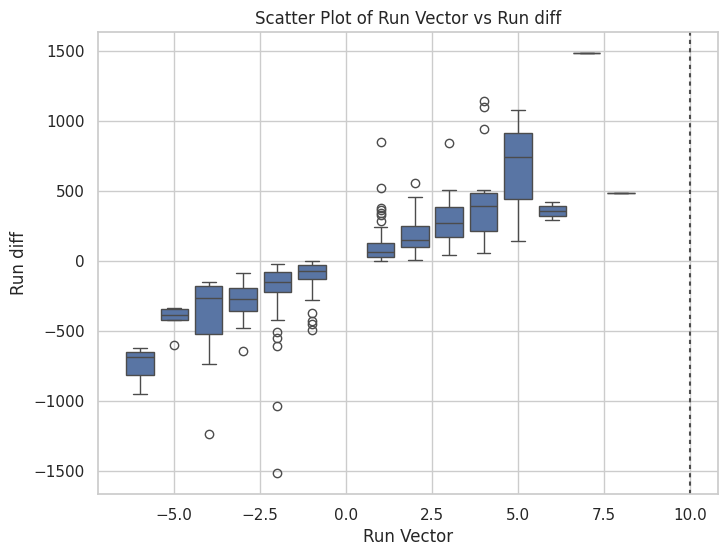

2023 12


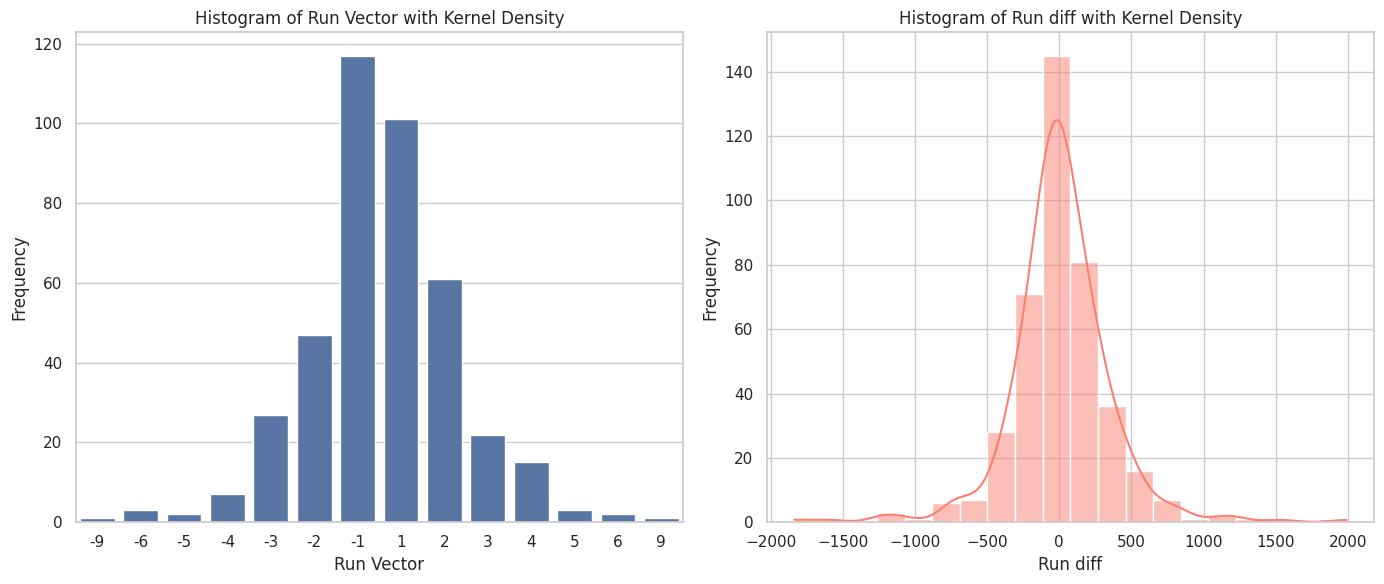

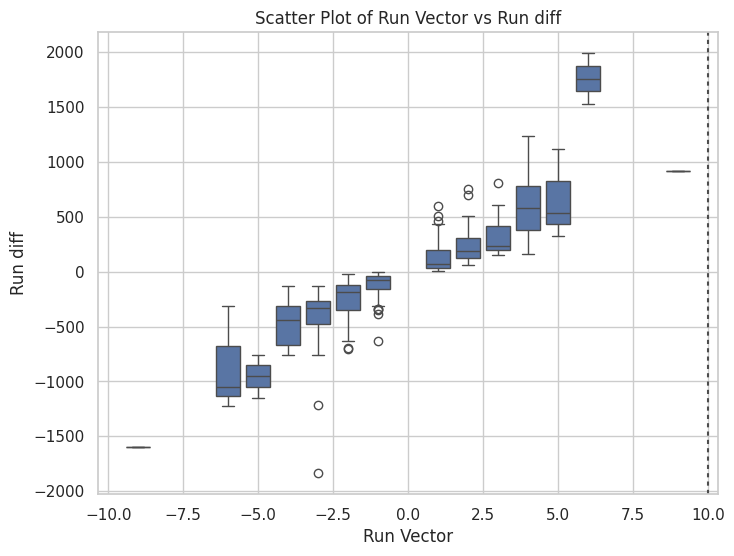

In [19]:
for year, months in values.items():
    for month_name, month in months.items():
        print(year, month_name)
        run_len = Variable(column='run_vector', label='Run Vector', type='categorical')
        run_diff = Variable(column='run_diff', label='Run diff', type='int')
        compare_two_variables(compute_runs(month), run_len, run_diff)

In [20]:

def stats_for_col(values, col):
    col_stats = {}
    for year, months in values.items():
        year_dict = {}
        for month_name, month in months.items():
            month_dict = {}
            col_kurtosis, col_mean, col_skew, col_std = compuse_stats_of_column(compute_runs(month)[col])
            month_dict["kurtosis"] = col_kurtosis
            month_dict["skew"] = col_skew
            month_dict["mean"] = col_mean
            month_dict["std"] = col_std
            year_dict[month_name] = month_dict
        col_stats[year] = pd.DataFrame(year_dict).T
    return col_stats


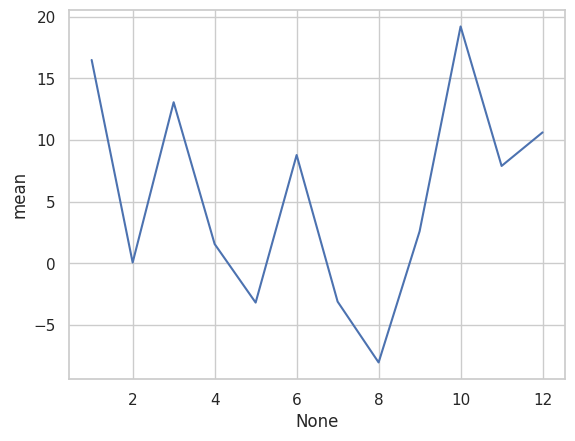

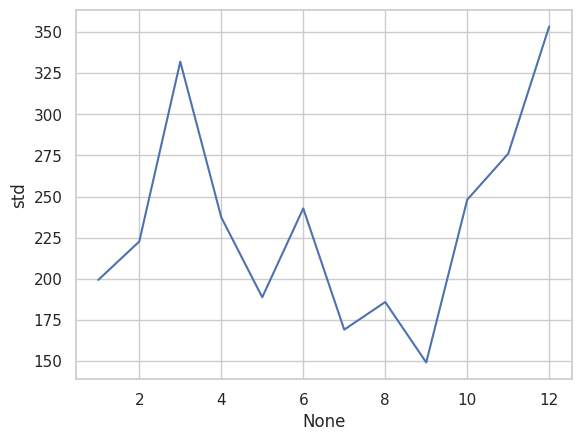

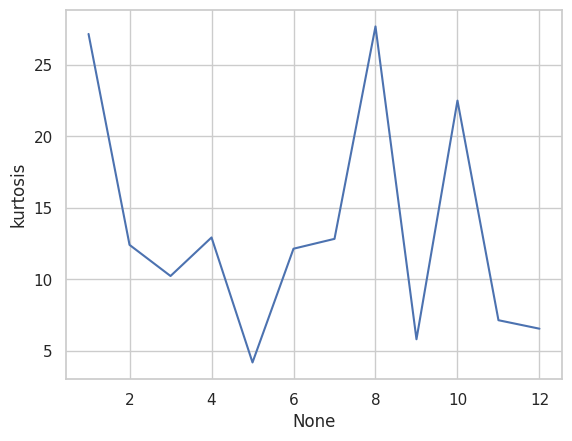

<Axes: xlabel='None', ylabel='skew'>

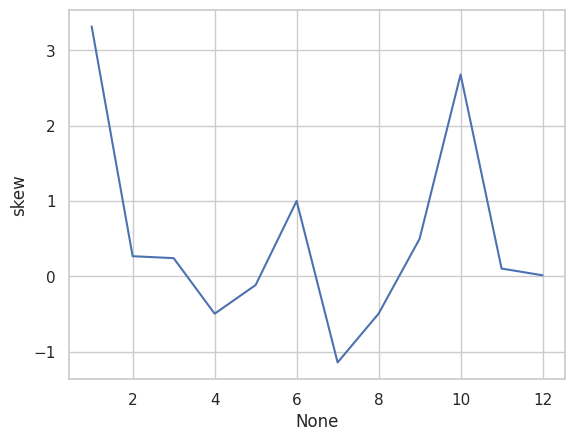

In [21]:
run_diff_stats = stats_for_col(values, "run_diff")

sns.lineplot(run_diff_stats[2023], y ="mean", x = run_diff_stats[2023].index)
plt.show()

sns.lineplot(run_diff_stats[2023], y ="std", x = run_diff_stats[2023].index)
plt.show()

sns.lineplot(run_diff_stats[2023], y ="kurtosis", x = run_diff_stats[2023].index)
plt.show()

sns.lineplot(run_diff_stats[2023], y ="skew", x = run_diff_stats[2023].index)

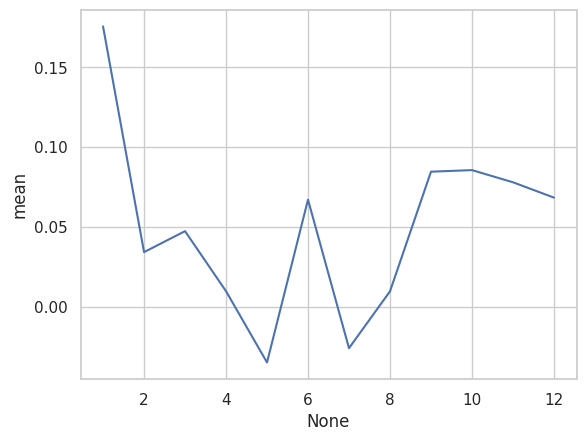

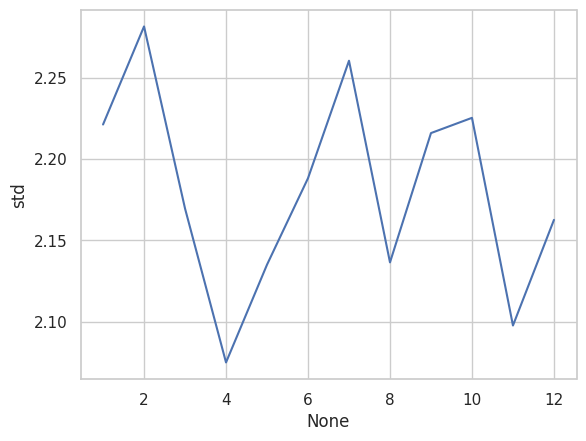

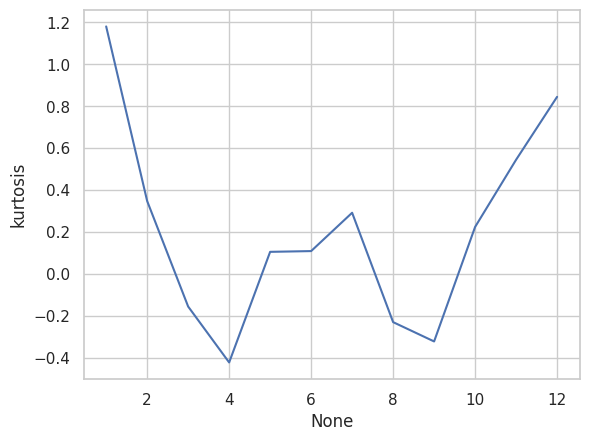

<Axes: xlabel='None', ylabel='skew'>

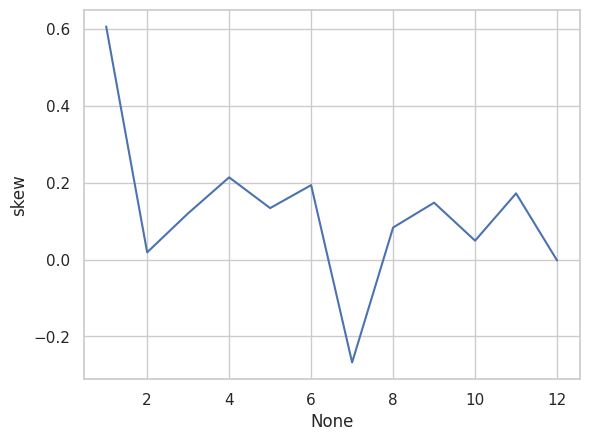

In [22]:
 run_vector_stats = stats_for_col(values, "run_vector")

sns.lineplot(run_vector_stats[2023], y ="mean", x = run_vector_stats[2023].index)
plt.show()

sns.lineplot(run_vector_stats[2023], y ="std", x = run_vector_stats[2023].index)
plt.show()

sns.lineplot(run_vector_stats[2023], y ="kurtosis", x = run_vector_stats[2023].index)
plt.show()

sns.lineplot(run_vector_stats[2023], y ="skew", x = run_vector_stats[2023].index)

# Whole year plots

In [23]:
df_2023 = pd.concat([month for month in values[2023].values()], ignore_index=True)

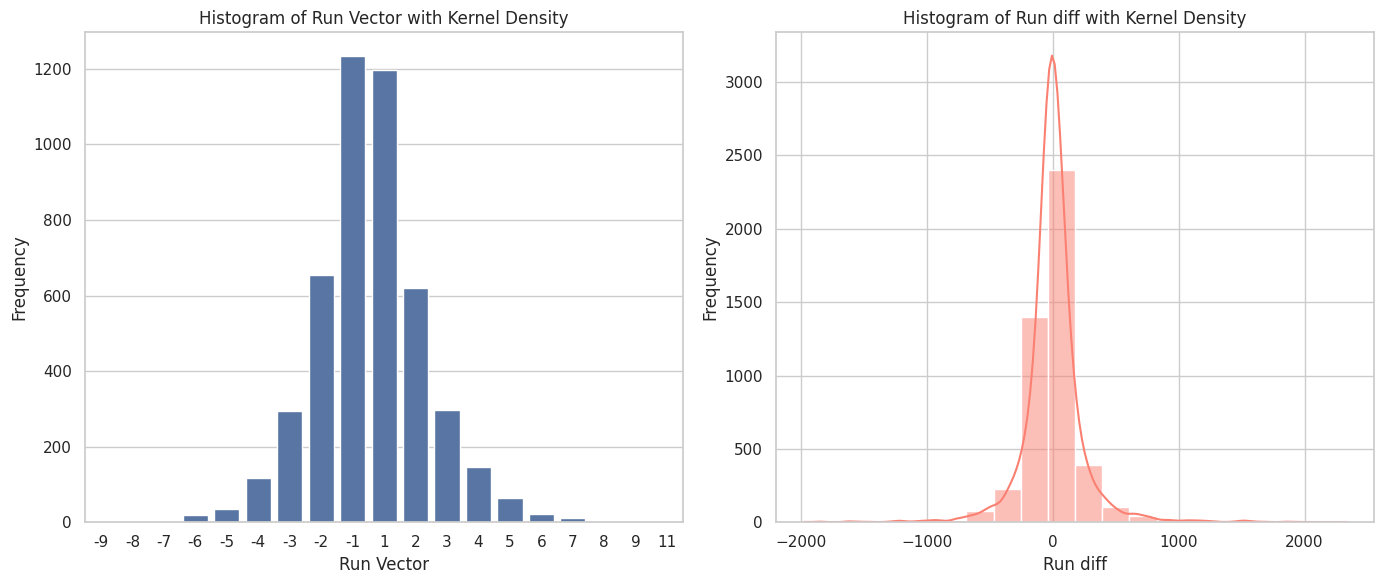

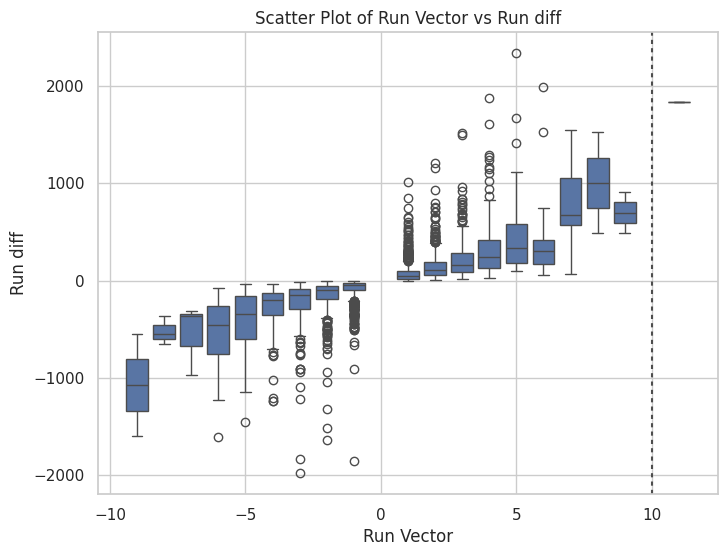

In [24]:
runs_2023 = compute_runs(df_2023)
compare_two_variables(runs_2023, run_len, run_diff)

In [25]:
compute_stats(runs_2023)

,Statistic,Run Length,Run Difference
0,Mean,1.849831,5.442494
1,Standard Deviation,1.159154,242.646739
2,Kurtosis,4.590129,14.527583
3,Skew,1.829987,0.493848


In [26]:
for i in range(1, 6):
    compare_two_variables(runs_2023[runs_2023['run_len'] == i], run_len, run_diff)pd.read_csv('your_data.csv'

SyntaxError: '(' was never closed (2813648222.py, line 2)

In [27]:
daily_vol_2023 = compute_daily_volatility_and_return(df_2023)

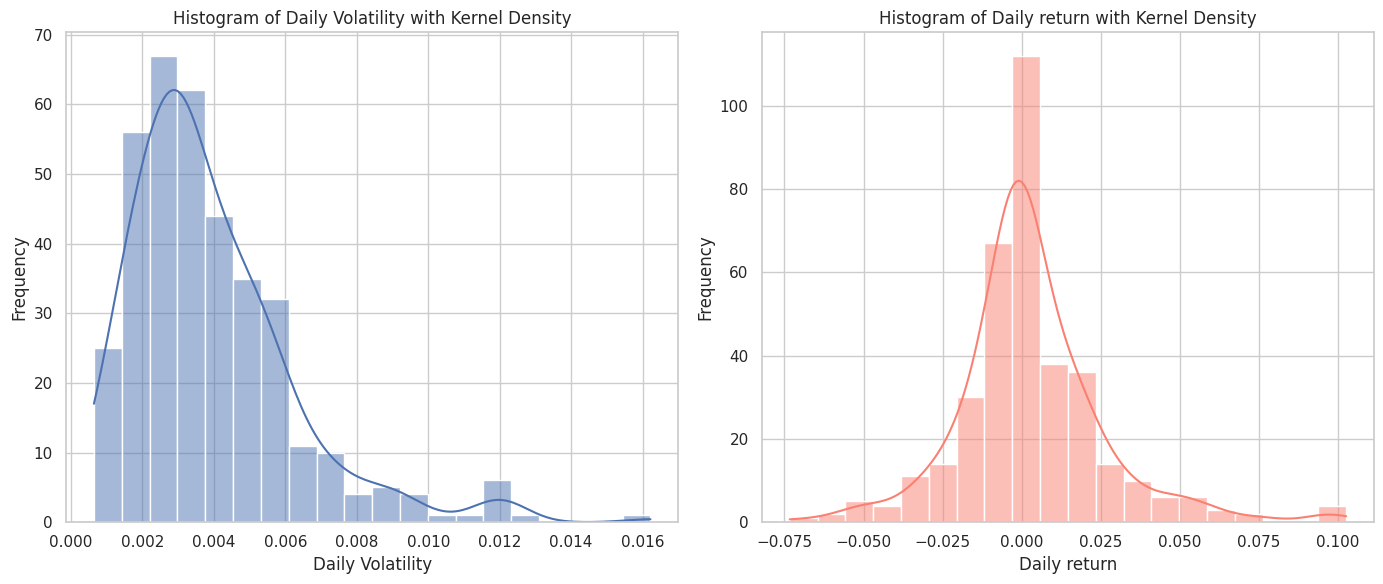

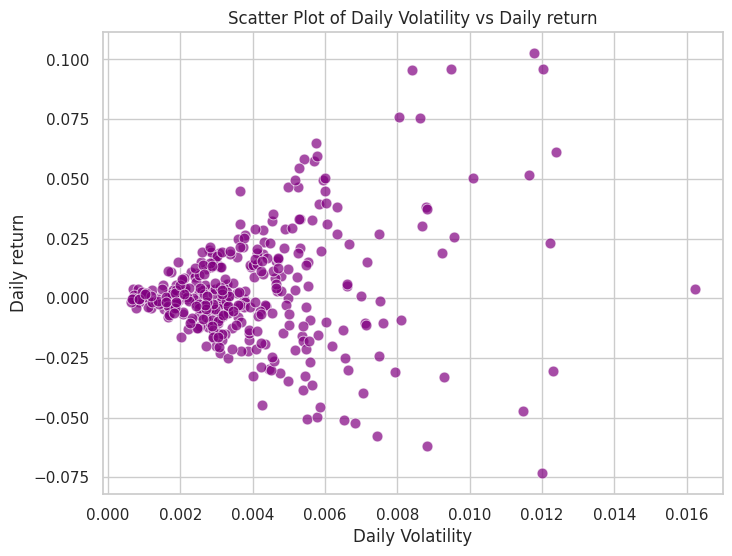

In [28]:
daily_return = Variable(column='daily_return', label='Daily return', type='int')
daily_vol = Variable(column='daily_volatility', label='Daily Volatility', type='int')
compare_two_variables(daily_vol_2023, daily_vol, daily_return)

# Slope


In [29]:
from sklearn.linear_model import LinearRegression

# Sample dataset, ensure 'open' column exists

df = df_2023
# Step 1: Create lagged variables for n=3
df['open_lag1'] = df['open'].shift(1)
df['open_lag2'] = df['open'].shift(2)
df['open_lag3'] = df['open'].shift(3)

# Drop rows with NaN values from lags
df.dropna(subset=['open_lag1', 'open_lag2', 'open_lag3'], inplace=True)

# Step 2: Perform autoregression
# Initialize a column to store the slope (we'll use the slope of 'open_lag1' as the main slope)
slopes = []

# Loop through the rows and fit an autoregression model for each row
for i in range(3, len(df)):
    # Select the lagged values and the current 'open' value
    X = df[['open_lag1', 'open_lag2', 'open_lag3']].iloc[i-3:i].values
    y = df['open'].iloc[i-3:i].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    
    # Store the slope (coefficient) of the first lag as the primary slope
    slopes.append(model.coef_[0])

# Fill slopes with NaN for the first rows and assign it to a new column
df['slope'] = [np.nan] * 3 + slopes
df.dropna(subset=['open_lag1', 'open_lag2', 'open_lag3'], inplace=True)

# Display the updated DataFrame
print(df[['open', 'open_lag1', 'open_lag2', 'open_lag3', 'slope']])

          open  open_lag1  open_lag2  open_lag3     slope
3     16533.04   16548.19   16551.47   16529.59       NaN
4     16522.22   16533.04   16548.19   16551.47       NaN
5     16530.71   16522.22   16533.04   16548.19       NaN
6     16539.79   16530.71   16522.22   16533.04  2.749820
7     16525.70   16539.79   16530.71   16522.22  0.998391
...        ...        ...        ...        ...       ...
8742  42656.69   42616.24   42592.47   42457.17  1.155958
8743  42619.04   42656.69   42616.24   42592.47  0.948368
8744  42558.02   42619.04   42656.69   42616.24 -0.372396
8745  42520.73   42558.02   42619.04   42656.69  1.503301
8746  42257.89   42520.73   42558.02   42619.04  0.783573

[8744 rows x 5 columns]


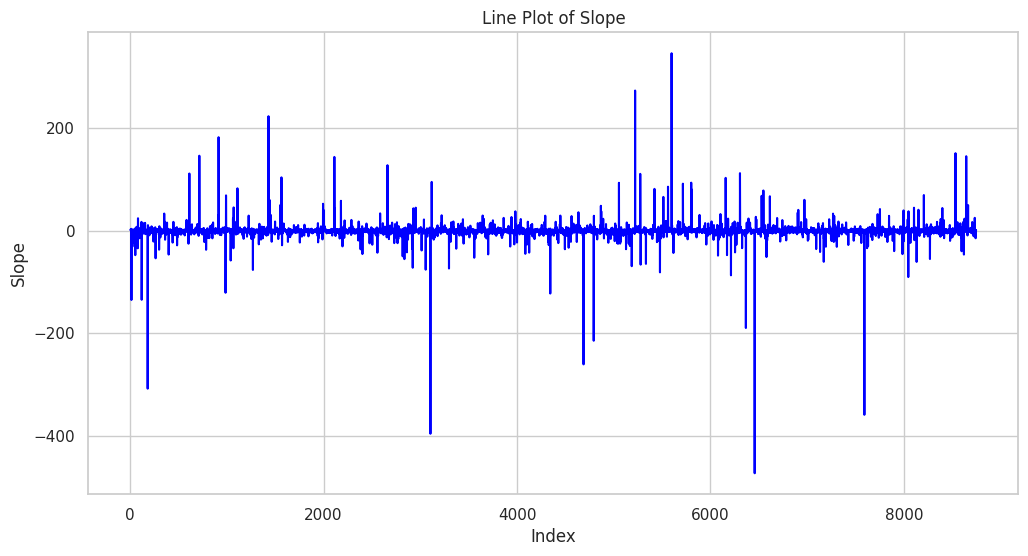

In [30]:
# Line plot of the slope
plt.figure(figsize=(12, 6))
sns.lineplot(data=df['slope'], color='blue')
plt.title('Line Plot of Slope')
plt.xlabel('Index')
plt.ylabel('Slope')
plt.show()



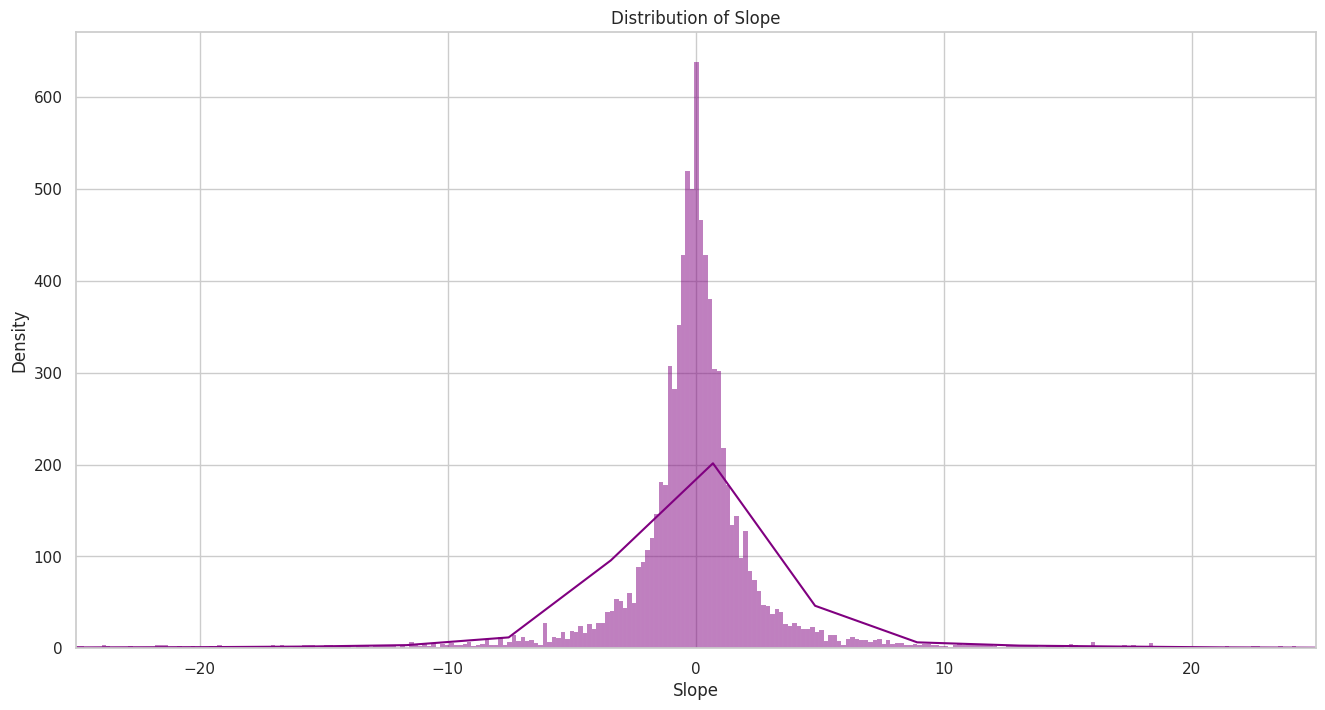

In [31]:
# Distribution plot of 'slope' with specified axis range
plt.figure(figsize=(16, 8))
sns.histplot(df['slope'].dropna(), kde=True, color='purple')
plt.title('Distribution of Slope')
plt.xlabel('Slope')
plt.ylabel('Density')

# Set the range for x and y axes
# plt.xlim(df['slope'].min(), df['slope'].max())  # Maximum range for x-axis based on data
plt.xlim(-25, 25)  # Maximum range for x-axis based on data
plt.ylim(0, None)  # Let y-axis adjust automatically

plt.show()

In [32]:
df['slope'].describe()

count    8741.000000
mean       -0.101947
std        13.921690
min      -472.903158
25%        -0.957736
50%        -0.027225
75%         0.893563
max       346.625482
Name: slope, dtype: float64

# moving average

In [33]:
df['mov_avg'] = df['open'].rolling(window=5).mean()
df['mov_avg_diff'] = df['open'] - df['mov_avg']


In [34]:
df['mov_avg_run'] = (df['open'] > df['mov_avg']).astype(int)

# Assign consecutive days
df['mov_avg_run'] = df['mov_avg_run'].groupby((df['mov_avg_run'] != df['mov_avg_run'].shift()).cumsum()).cumcount() + 1
df['mov_avg_vector'] = df['mov_avg_run'] 
df.loc[df['open'] < df['mov_avg'], 'mov_avg_vector'] *= -1


,open_time,open,high,low,close,volume,close_time,quote_assets_volume,number_of_trades,taker_buy_base_asset_vol,...,date,hourly_return,open_lag1,open_lag2,open_lag3,slope,mov_avg,mov_avg_diff,mov_avg_run,mov_avg_vector
3,1672545600000,16533.04,16535.97,16511.92,16521.85,4285.00909,1672549199999,7.080264e+07,129535,2188.40175,...,2023-01-01,-0.000677,16548.19,16551.47,16529.59,NaN,NaN,NaN,1,1
4,1672549200000,16522.22,16534.98,16512.30,16530.71,3717.37178,1672552799999,6.141222e+07,118541,1925.65583,...,2023-01-01,0.000536,16533.04,16548.19,16551.47,NaN,NaN,NaN,2,2
5,1672552800000,16530.71,16550.00,16528.81,16539.79,3344.90206,1672556399999,5.532956e+07,106074,1625.16179,...,2023-01-01,0.000549,16522.22,16533.04,16548.19,NaN,NaN,NaN,3,3
6,1672556400000,16539.79,16544.57,16499.01,16526.19,5184.95822,1672559999999,8.566359e+07,148545,2476.59015,...,2023-01-01,-0.000822,16530.71,16522.22,16533.04,2.749820,NaN,NaN,4,4
7,1672560000000,16525.70,16534.03,16508.45,16513.34,4271.92023,1672563599999,7.056838e+07,135605,2092.40270,...,2023-01-01,-0.000778,16539.79,16530.71,16522.22,0.998391,16530.292,-4.592,5,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8742,1704049200000,42656.69,42695.44,42586.91,42619.04,703.55791,1704052799999,2.999955e+07,33260,341.33239,...,2023-12-31,-0.000883,42616.24,42592.47,42457.17,1.155958,42569.908,86.782,3,3
8743,1704052800000,42619.04,42680.36,42504.56,42558.01,1015.14035,1704056399999,4.323263e+07,42477,518.20861,...,2023-12-31,-0.001432,42656.69,42616.24,42592.47,0.948368,42588.322,30.718,4,4
8744,1704056400000,42558.02,42670.44,42520.72,42520.72,923.43813,1704059999999,3.933675e+07,36012,478.31848,...,2023-12-31,-0.000876,42619.04,42656.69,42616.24,-0.372396,42608.492,-50.472,1,-1
8745,1704060000000,42520.73,42591.10,42056.00,42257.88,1811.59411,1704063599999,7.676401e+07,75332,820.10687,...,2023-12-31,-0.006181,42558.02,42619.04,42656.69,1.503301,42594.144,-73.414,2,-2


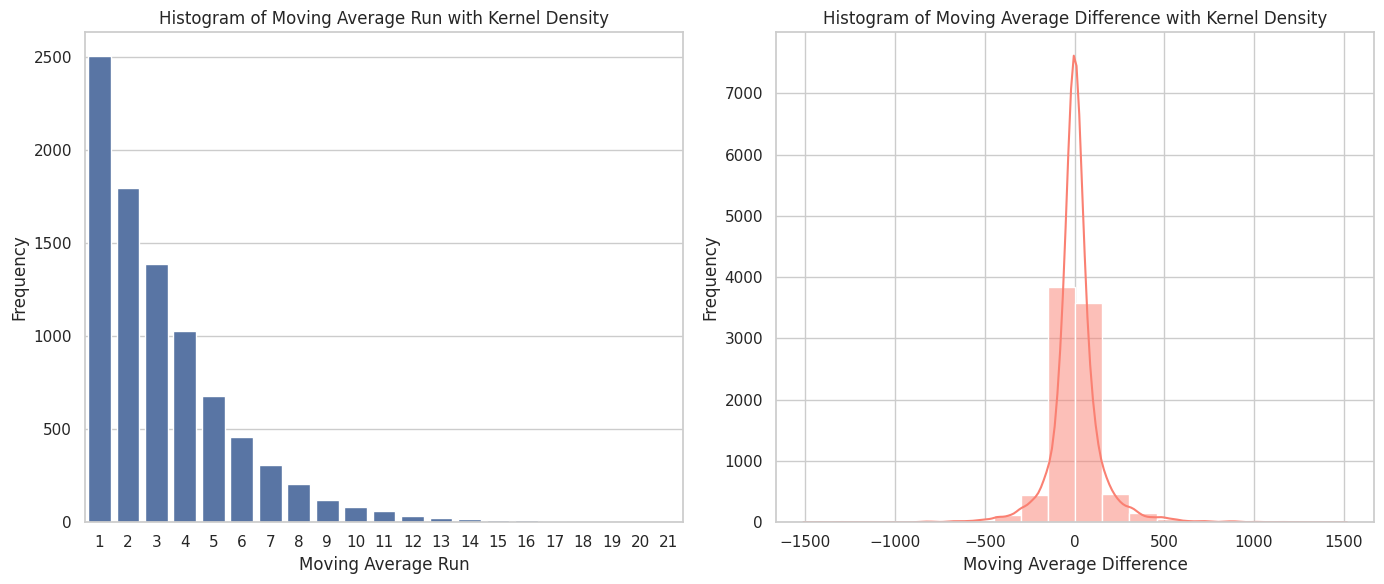

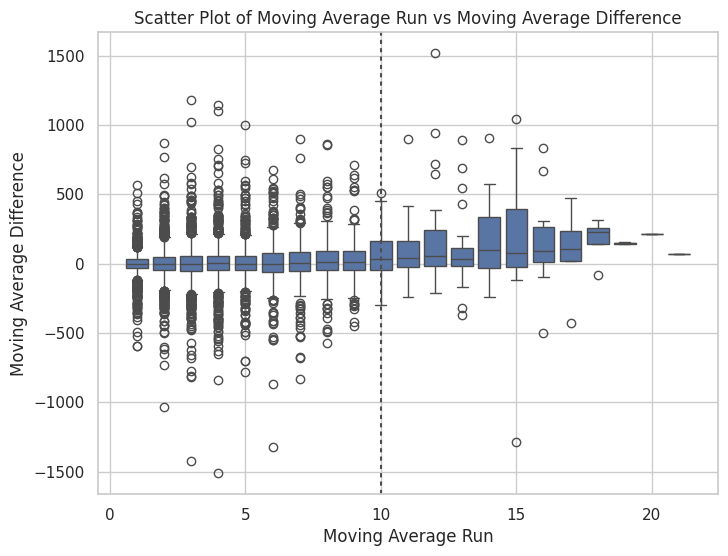

In [35]:
mog_avg_dif = Variable(column = 'mov_avg_diff', label='Moving Average Difference', type='int')
mov_avg_run = Variable(column = 'mov_avg_run', label='Moving Average Run', type='categorical')
compare_two_variables(df, mov_avg_run,mog_avg_dif )

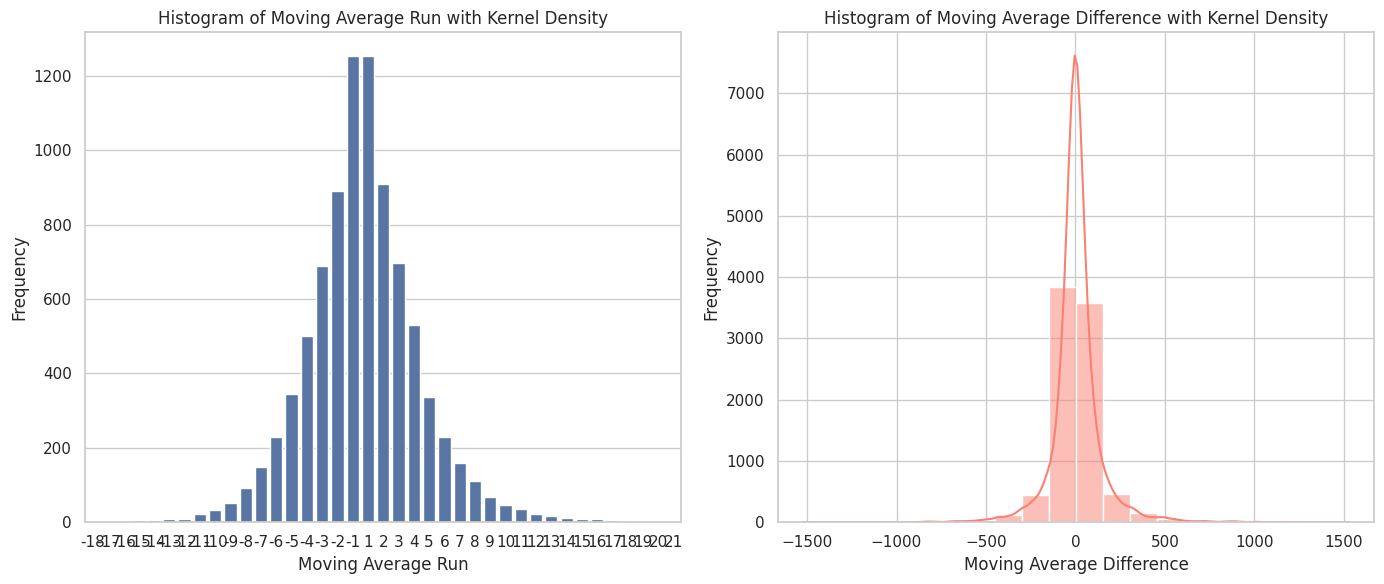

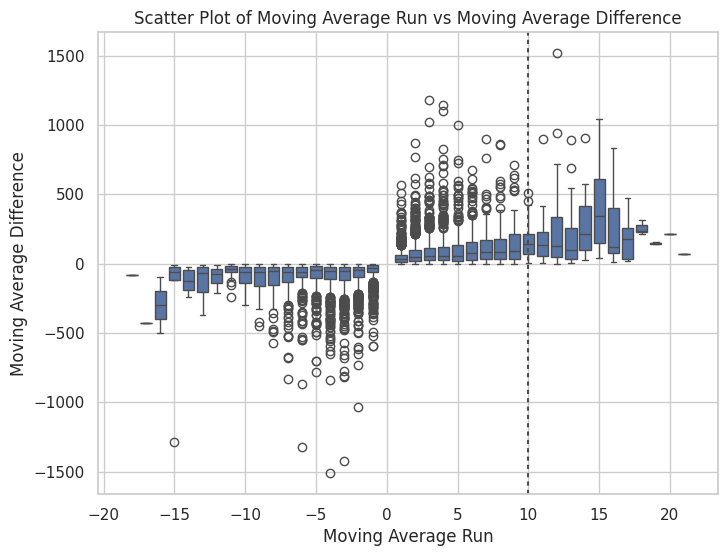

In [36]:
mog_avg_dif = Variable(column = 'mov_avg_diff', label='Moving Average Difference', type='int')
mov_avg_vector = Variable(column = 'mov_avg_vector', label='Moving Average Run', type='categorical')
compare_two_variables(df, mov_avg_vector,mog_avg_dif )

In [40]:
def test(df):
    # Identify the sign of mov_avg_diff
    df['sign'] = df['mov_avg_diff'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'zero')

    # Calculate the run number by checking when the sign changes
    df['run_number'] = (df['sign'] != df['sign'].shift()).cumsum()

    # Calculate the run lengths
    df['mov_avg_diff_run'] = df.groupby('run_number')['run_number'].transform('size')

    # Assign positive or negative based on the sign
    df['mov_avg_diff_run'] = df['mov_avg_diff_run'] * df['mov_avg_diff'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

    # Display the DataFrame with the new column
    print(df[['mov_avg_diff', 'sign', 'mov_avg_diff_run', 'run_number']])
test(df.copy())

      mov_avg_diff      sign  mov_avg_diff_run  run_number
3              NaN      zero                 0           1
4              NaN      zero                 0           1
5              NaN      zero                 0           1
6              NaN      zero                 0           1
7           -4.592  negative                -2           2
...            ...       ...               ...         ...
8742        86.782  positive                 4        2507
8743        30.718  positive                 4        2507
8744       -50.472  negative                -3        2508
8745       -73.414  negative                -3        2508
8746      -264.584  negative                -3        2508

[8744 rows x 4 columns]


In [39]:
df[['mov_avg_diff',]].head()

,mov_avg_diff
3,NaN
4,NaN
5,NaN
6,NaN
7,-4.592
